In [36]:
# jupyter nbconvert --to script assignment1Ander.ipynb


SyntaxError: invalid syntax (1822742076.py, line 1)

In [601]:
!pip install pandas nltk scikit-learn

In [5]:
import pandas as pd
import nltk

In [6]:
dtypes = {
    'ArticleId': 'int32',
    'Text': 'str',
    'Category': 'category'
}
data_train = pd.read_csv('data/BBC News Train.csv', dtype=dtypes, encoding='utf-8', index_col='ArticleId')
data_test = pd.read_csv('data/BBC News Test.csv', dtype={'ArticleId': 'int32', 'Text': 'str'}, encoding='utf-8', index_col='ArticleId')
data_test_solution = pd.read_csv('data/BBC News Sample Solution.csv', dtype={'ArticleId': 'int32', 'Category': 'category'}, encoding='utf-8', index_col='ArticleId')
data_test['Category'] = data_test_solution['Category']
data = pd.concat([data_train, data_test])
data.head(10)

,Text,Category
ArticleId,,
1833,worldcom ex-boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens in ...,business
1976,lifestyle governs mobile choice faster bett...,tech
917,enron bosses in $168m payout eighteen former e...,business
1582,howard truanted to play snooker conservative...,politics
651,wales silent on grand slam talk rhys williams ...,sport
1797,french honour for director parker british film...,entertainment
2034,car giant hit by mercedes slump a slump in pro...,business


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2225 entries, 1833 to 471
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Text      2225 non-null   object  
 1   Category  2225 non-null   category
dtypes: category(1), object(1)
memory usage: 28.5+ KB


In [8]:
data.Category.value_counts()

Category
sport            493
business         483
politics         421
entertainment    420
tech             408
Name: count, dtype: int64

## Preprocessing

### Lowercasing

In [9]:
def lowercase_data(data: pd.DataFrame) -> pd.DataFrame:
    new_data = data.copy()
    new_data['Text'] = new_data['Text'].str.lower()
    return new_data

### Punctuation Removal

In [10]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-z]+')

def remove_punctuation(data: pd.DataFrame) -> pd.DataFrame:
    new_data = data.copy()
    new_data['Text'] = new_data['Text'].apply(tokenizer.tokenize)
    return new_data

### Stopwords Removal

In [11]:
from nltk.corpus import stopwords

nltk.download('stopwords')

def remove_stopwords(data: pd.DataFrame) -> pd.DataFrame:
    stop_words = set(stopwords.words('english'))
    new_data = data.copy()
    new_data['Text'] = new_data['Text'].apply(lambda x: [word for word in tuple(x) if word not in stop_words and len(word) > 3])
    return new_data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Lemmatization

In [12]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
def lemmatize_data(data: pd.DataFrame) -> pd.DataFrame:
    lemmatizer = WordNetLemmatizer()
    new_data = data.copy()
    new_data['Text'] = new_data['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))
    return new_data

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Stemming

In [13]:
from nltk.stem import PorterStemmer

nltk.download('punkt')
def stem_data(data: pd.DataFrame) -> pd.DataFrame:
    stemmer = PorterStemmer()
    new_data = data.copy()
    new_data['Text'] = new_data['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x]))
    return new_data

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Compute tf-idf

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(data: pd.DataFrame) -> (TfidfVectorizer, pd.DataFrame):
    # Drop rows with NaN values in the 'Text' column
    data = data.dropna(subset=['Text'])
    vectorizer = TfidfVectorizer()
    
    X = vectorizer.fit_transform(data['Text'])
    return vectorizer, X

In [15]:
data = lowercase_data(data)
data = remove_punctuation(data)
data = remove_stopwords(data)

data = lemmatize_data(data)
# data_stemmed = stem_data(data)

# Using tf-idf

4 different users: the first one being interested in politics and soccer, the second in music and films, the third in cars and politics and the fourth in soccer alone.

In [103]:
user_interests = {
    1: ['politics', 'soccer'],
    2: ['music', 'films'],
    3: ['cars', 'politics'],
    4: ['soccer']
}

In [16]:
user_interests = {
    1: ['kennedy'],
    2: ['entertainment'],
    3: ['sports'],
    4: ['tech'],
    5: ['business']
}

In [17]:
data

,Text,Category
ArticleId,,
1833,worldcom bos launch defence lawyer defending f...,business
154,german business confidence slide german busine...,business
1101,poll indicates economic gloom citizen majority...,business
1976,lifestyle governs mobile choice faster better ...,tech
917,enron boss payout eighteen former enron direct...,business
...,...,...
1923,probe alitalia state european commission offic...,sport
373,play grammy award show irish rock band play li...,tech
1704,sport betting rule spotlight group peer called...,business


In [18]:
from sklearn.metrics.pairwise import cosine_similarity
# Combine all documents into a single list
all_documents = data['Text']

# Vectorize documents using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.05,  stop_words='english', max_features=1000)
document_vectors = vectorizer.fit_transform(all_documents)
len(vectorizer.vocabulary_)

1000

In [19]:
num_documents_to_retrieve = 10  # Number of documents to retrieve for each user
user_relevant_documents = {}
categories = data['Category'].unique()

for user_id, interests in user_interests.items():
    relevant_documents = []
    for interest in interests:
        query_vector = vectorizer.transform([interest])
        similarity_scores = cosine_similarity(query_vector, document_vectors)[0]
        top_documents_indices = similarity_scores.argsort()[-num_documents_to_retrieve:][::-1]
        top_documents = [(data.iloc[i]['Text'], similarity_scores[i]) for i in top_documents_indices]
        relevant_documents.extend(top_documents)
    
    # Sort the relevant documents by their similarity scores and select the top 10
    relevant_documents.sort(key=lambda x: x[1], reverse=True)
    top_10_documents = relevant_documents[:num_documents_to_retrieve]
    
    user_relevant_documents[user_id] = top_10_documents

In [136]:
categories

['business', 'tech', 'politics', 'sport', 'entertainment']
Categories (5, object): ['business', 'entertainment', 'politics', 'sport', 'tech']

User 1 Interests: ['politics']
     Document: court halt mark morrison album Similarity Score: 0.5719763
     Document: confusion high definition crit Similarity Score: 0.55491936
     Document: ethiopia crop production ethio Similarity Score: 0.5127802
     Document: detention ruling urged governm Similarity Score: 0.5117885
     Document: santy worm make unwelcome visi Similarity Score: 0.50219214
     Document: ukip candidate suspended euros Similarity Score: 0.5007821
     Document: bosvelt optimistic deal manche Similarity Score: 0.49390337
     Document: adriano chelsea link rejected  Similarity Score: 0.49390337
     Document: copy protection strengthened d Similarity Score: 0.49235088
     Document: italy ireland moment magic bri Similarity Score: 0.481332

In [137]:
# Print or use user_relevant_documents as needed
for user_id, relevant_documents in user_relevant_documents.items():
    print(f"User {user_id} relevant documents:")
    for i, (document, similarity_score) in enumerate(relevant_documents, 1):
        print(f"{i}. Similarity Score: {similarity_score:.4f}\n {document}\n")


User 1 relevant documents:
1. Similarity Score: 0.6906
 dems unveil election slogan liberal democrat present real alternative forthcoming general election campaign charles kennedy said unveiling slogan party spring conference said glass ceiling ambition told delegate labour abused public trust tory failed oppose response conservative insisted party understood forgotten majority speaking harrogate kennedy said people want credible principled political party offer different vision britain liberal democrat stood iraq said also provided strong opposition government plan card anti terror measure taxation said voted conservative good vote wasted people needed party listening concern party prepared stand party said prime minister responding claim tory party chairman liam said like labour dems soft crime support higher tax oppose controlled immigration support giving europe control life kennedy also outlined party plan impose income rate earnings year money would used help policy abolishing un

In [138]:
# Print or use user_relevant_documents as needed
for user_id, relevant_documents in user_relevant_documents.items():
    print(f"User {user_id} relevant documents:")
    for i, (document, similarity_score) in enumerate(relevant_documents, 1):
        print(f"{i}. Similarity Score: {similarity_score:.4f}\n {document}\n")


User 1 relevant documents:
1. Similarity Score: 0.6906
 dems unveil election slogan liberal democrat present real alternative forthcoming general election campaign charles kennedy said unveiling slogan party spring conference said glass ceiling ambition told delegate labour abused public trust tory failed oppose response conservative insisted party understood forgotten majority speaking harrogate kennedy said people want credible principled political party offer different vision britain liberal democrat stood iraq said also provided strong opposition government plan card anti terror measure taxation said voted conservative good vote wasted people needed party listening concern party prepared stand party said prime minister responding claim tory party chairman liam said like labour dems soft crime support higher tax oppose controlled immigration support giving europe control life kennedy also outlined party plan impose income rate earnings year money would used help policy abolishing un

In [97]:
from evaltools import evaluate, gen_eval_dataset

evaluar cin la funcion del profesor

Precision and Recall at k for k=1,...,10
	Query 1
		P(1)=0/1=0.00,	R(1)=0/6=0.00
		P(2)=0/2=0.00,	R(2)=0/6=0.00
		P(3)=1/3=0.33,	R(3)=1/6=0.17
		P(4)=1/4=0.25,	R(4)=1/6=0.17
		P(5)=1/5=0.20,	R(5)=1/6=0.17
		P(6)=2/6=0.33,	R(6)=2/6=0.33
		P(7)=3/7=0.43,	R(7)=3/6=0.50
		P(8)=4/8=0.50,	R(8)=4/6=0.67
		P(9)=5/9=0.56,	R(9)=5/6=0.83
		P(10)=6/10=0.60,	R(10)=6/6=1.00
	Query 2
		P(1)=0/1=0.00,	R(1)=0/4=0.00
		P(2)=0/2=0.00,	R(2)=0/4=0.00
		P(3)=0/3=0.00,	R(3)=0/4=0.00
		P(4)=0/4=0.00,	R(4)=0/4=0.00
		P(5)=0/5=0.00,	R(5)=0/4=0.00
		P(6)=1/6=0.17,	R(6)=1/4=0.25
		P(7)=1/7=0.14,	R(7)=1/4=0.25
		P(8)=2/8=0.25,	R(8)=2/4=0.50
		P(9)=3/9=0.33,	R(9)=3/4=0.75
		P(10)=4/10=0.40,	R(10)=4/4=1.00
	Query 3
		P(1)=1/1=1.00,	R(1)=1/5=0.20
		P(2)=1/2=0.50,	R(2)=1/5=0.20
		P(3)=2/3=0.67,	R(3)=2/5=0.40
		P(4)=2/4=0.50,	R(4)=2/5=0.40
		P(5)=2/5=0.40,	R(5)=2/5=0.40
		P(6)=2/6=0.33,	R(6)=2/5=0.40
		P(7)=3/7=0.43,	R(7)=3/5=0.60
		P(8)=3/8=0.38,	R(8)=3/5=0.60
		P(9)=4/9=0.44,	R(9)=4/5=0.80
		P(10)=5/10=0.50,	R(10)=5/

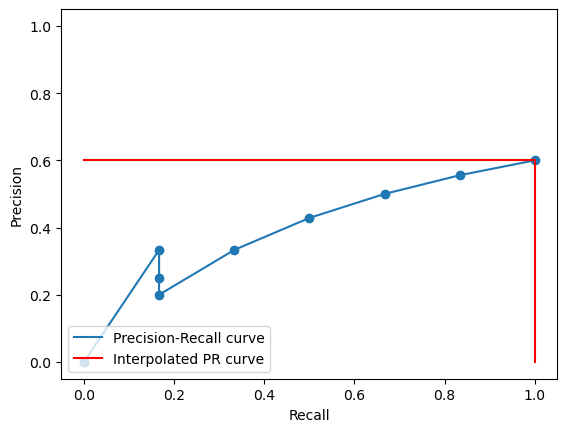

	Query 2


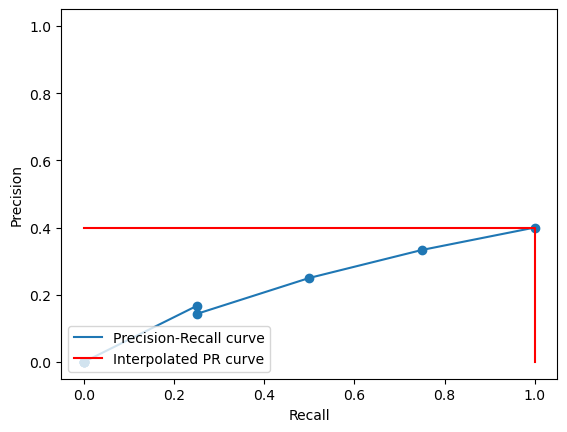

	Query 3


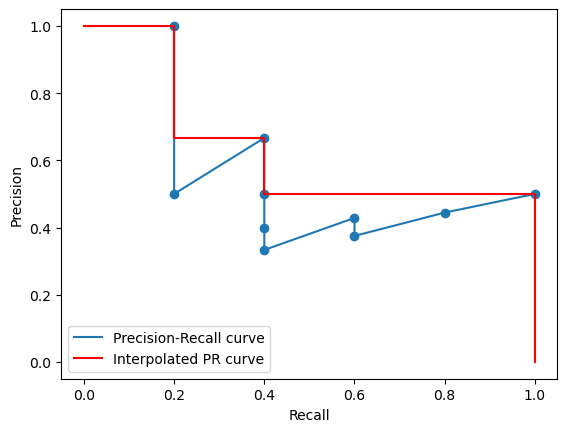

	Query 4


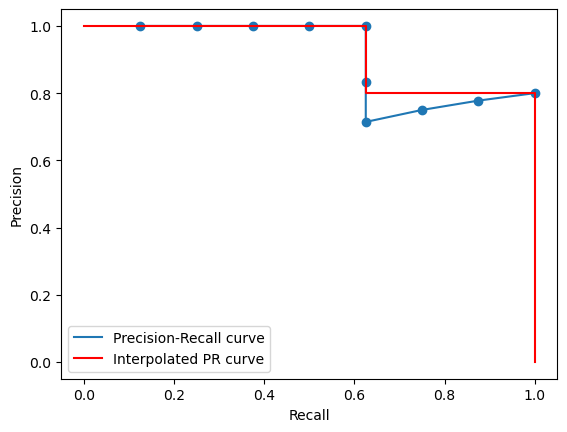

	Query 5


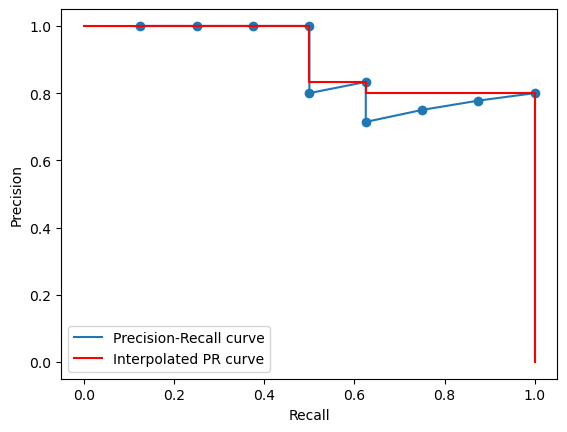

	Query 6


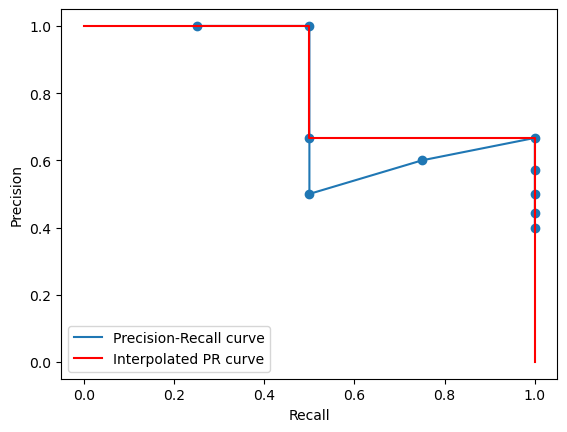

	Query 7


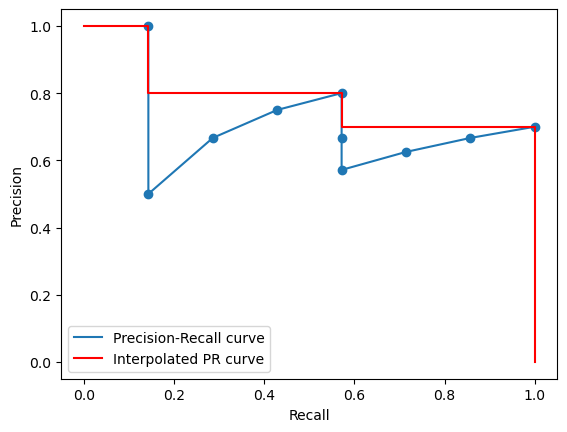

	Query 8


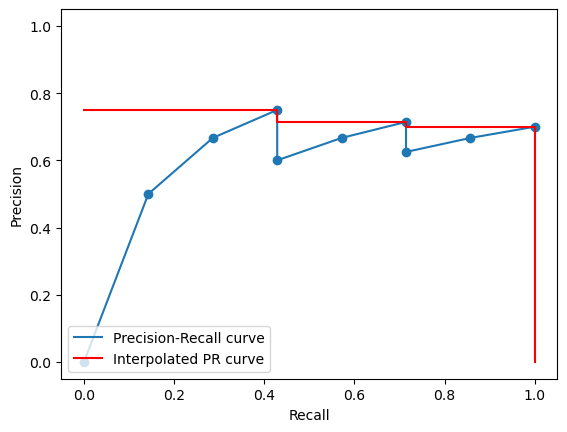

	Query 9


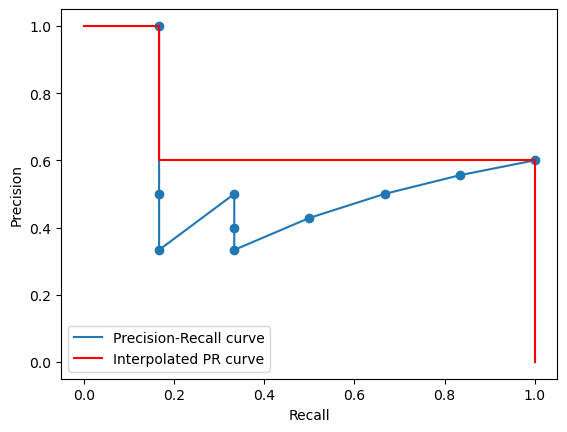

	Query 10


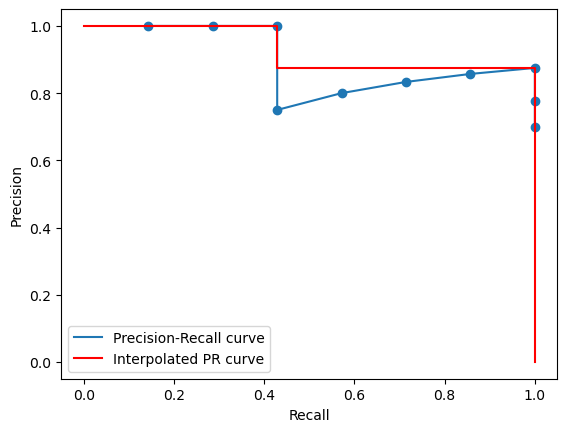


 Determine R-precision for each query
	Query 1
		Number of relevant documents: 6 --> P(6)=0.33
	Query 2
		Number of relevant documents: 4 --> P(4)=0.00
	Query 3
		Number of relevant documents: 5 --> P(5)=0.40
	Query 4
		Number of relevant documents: 8 --> P(8)=0.75
	Query 5
		Number of relevant documents: 8 --> P(8)=0.75
	Query 6
		Number of relevant documents: 4 --> P(4)=0.50
	Query 7
		Number of relevant documents: 7 --> P(7)=0.57
	Query 8
		Number of relevant documents: 7 --> P(7)=0.71
	Query 9
		Number of relevant documents: 6 --> P(6)=0.33
	Query 10
		Number of relevant documents: 7 --> P(7)=0.86

 Calculate the Mean Average Precision
	Query 1
		AP=1/6 {P(3) + P(6) + P(7) + P(8) + P(9) + P(10)}=0.46
	Query 2
		AP=1/4 {P(6) + P(8) + P(9) + P(10)}=0.29
	Query 3
		AP=1/5 {P(1) + P(3) + P(7) + P(9) + P(10)}=0.61
	Query 4
		AP=1/8 {P(1) + P(2) + P(3) + P(4) + P(5) + P(8) + P(9) + P(10)}=0.92
	Query 5
		AP=1/8 {P(1) + P(2) + P(3) + P(4) + P(6) + P(8) + P(9) + P(10)}=0.90
	Query 6
		AP=

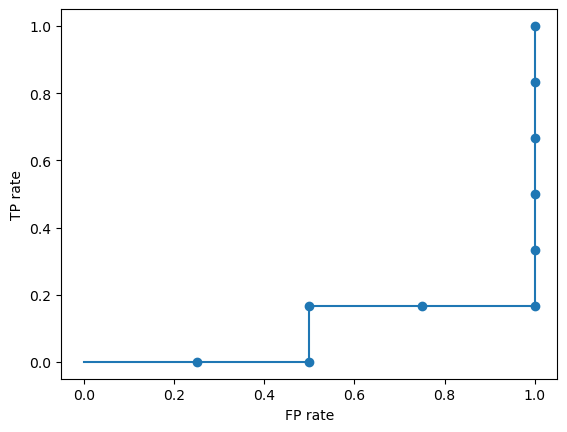

	AUC = 0.04 + 0.04 =  0.08


	Query 2


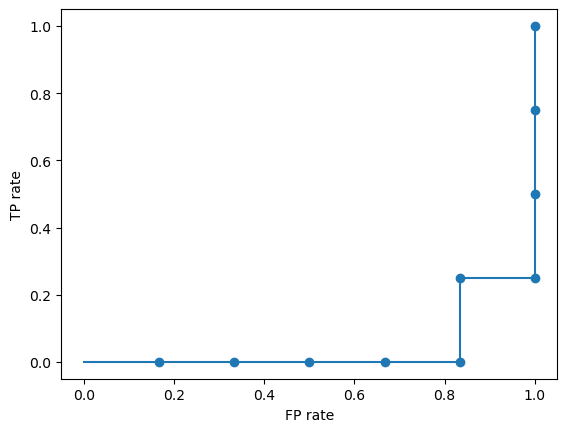

	AUC = 0.04 =  0.04


	Query 3


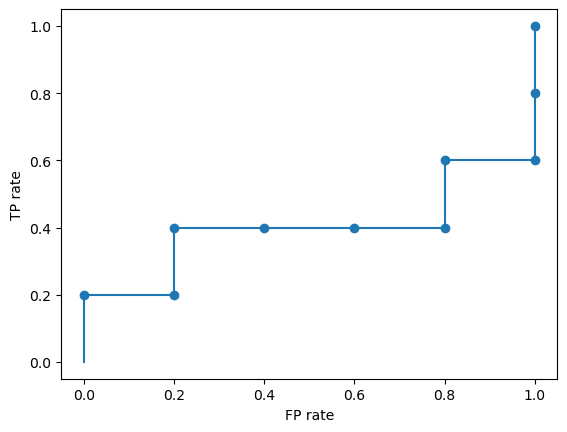

	AUC = 0.04 + 0.08 + 0.08 + 0.08 + 0.12 =  0.40


	Query 4


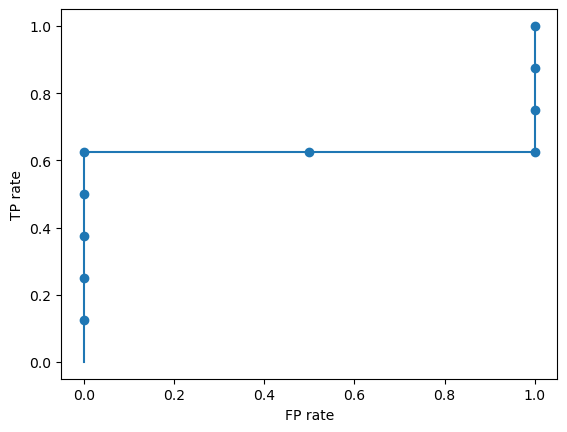

	AUC = 0.31 + 0.31 =  0.62


	Query 5


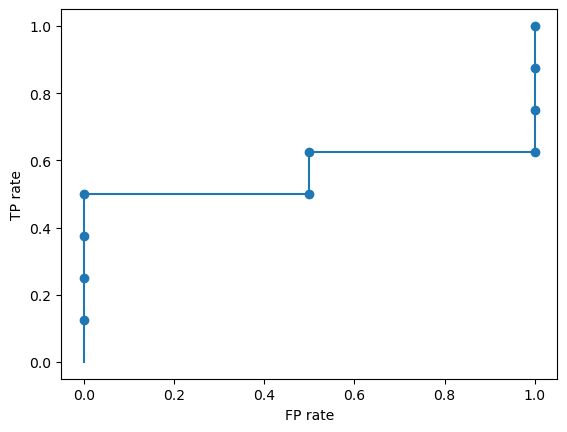

	AUC = 0.25 + 0.31 =  0.56


	Query 6


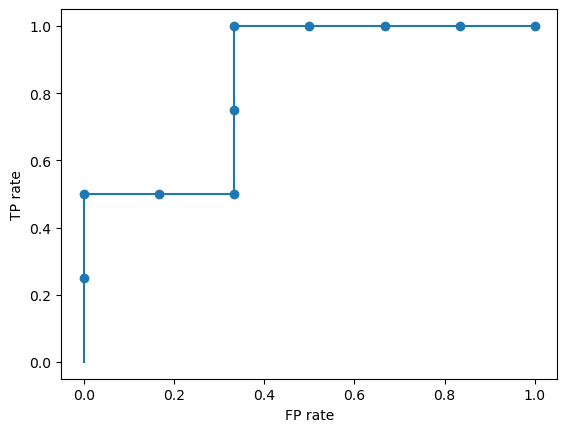

	AUC = 0.08 + 0.08 + 0.17 + 0.17 + 0.17 + 0.17 =  0.83


	Query 7


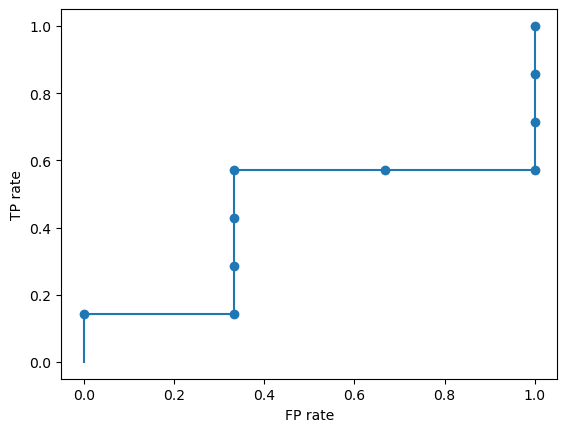

	AUC = 0.05 + 0.19 + 0.19 =  0.43


	Query 8


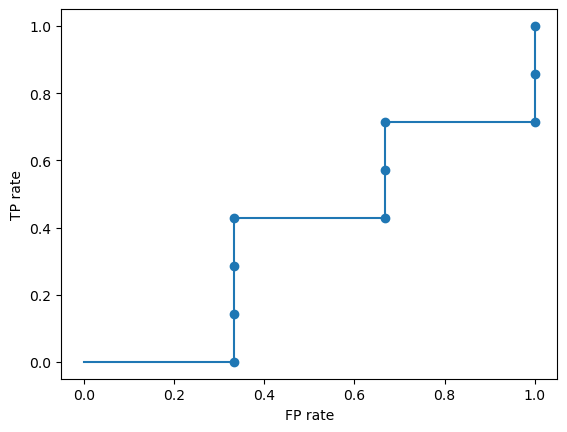

	AUC = 0.14 + 0.24 =  0.38


	Query 9


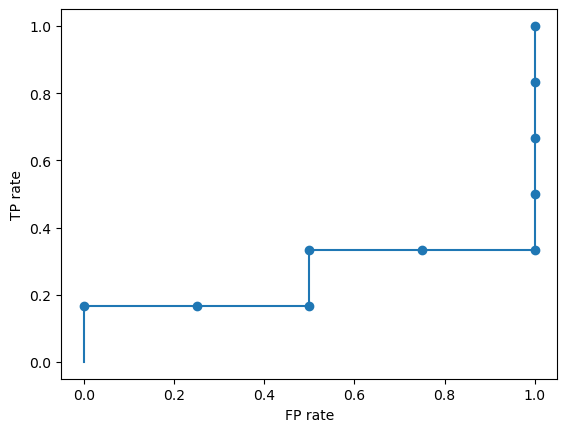

	AUC = 0.04 + 0.04 + 0.08 + 0.08 =  0.25


	Query 10


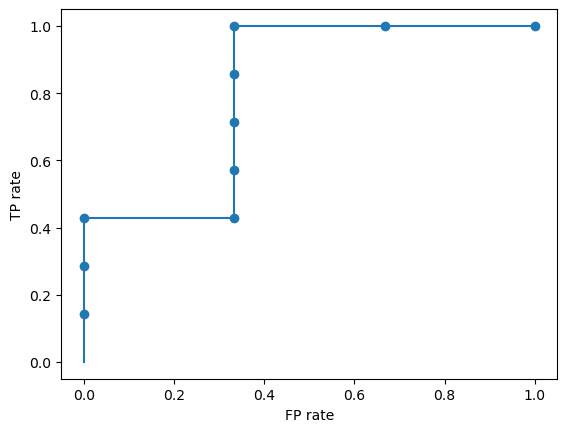

	AUC = 0.14 + 0.33 + 0.33 =  0.81


Precision and Recall at k for k=1,...,10
	Query 1
		P(1)=0/1=0.00,	R(1)=0/4=0.00
		P(2)=0/2=0.00,	R(2)=0/4=0.00
		P(3)=0/3=0.00,	R(3)=0/4=0.00
		P(4)=1/4=0.25,	R(4)=1/4=0.25
		P(5)=2/5=0.40,	R(5)=2/4=0.50
		P(6)=2/6=0.33,	R(6)=2/4=0.50
		P(7)=3/7=0.43,	R(7)=3/4=0.75
		P(8)=3/8=0.38,	R(8)=3/4=0.75
		P(9)=4/9=0.44,	R(9)=4/4=1.00
		P(10)=4/10=0.40,	R(10)=4/4=1.00
	Query 2
		P(1)=1/1=1.00,	R(1)=1/1=1.00
		P(2)=1/2=0.50,	R(2)=1/1=1.00
		P(3)=1/3=0.33,	R(3)=1/1=1.00
		P(4)=1/4=0.25,	R(4)=1/1=1.00
		P(5)=1/5=0.20,	R(5)=1/1=1.00
		P(6)=1/6=0.17,	R(6)=1/1=1.00
		P(7)=1/7=0.14,	R(7)=1/1=1.00
		P(8)=1/8=0.12,	R(8)=1/1=1.00
		P(9)=1/9=0.11,	R(9)=1/1=1.00
		P(10)=1/10=0.10,	R(10)=1/1=1.00
	Query 3
		P(1)=1/1=1.00,	R(1)=1/8=0.12
		P(2)=2/2=1.00,	R(2)=2/8=0.25
		P(3)=2/3=0.67,	R(3)=2/8=0.25
		P(4)=2/4=0.50,	R(4)=2/8=0.25
		P(5)=3/5=0.60,	R(5)=3/8=0.38
		P(6)=4/6=0.67,	R(6)=4/8=0.50
		P(7)=5/7=0.71,	R(7)=5/8=0.62
		P(8)=6/8=0.75,	R(8)=6/8=0.75
		P(9)=7/9=0.78,	R(9)=

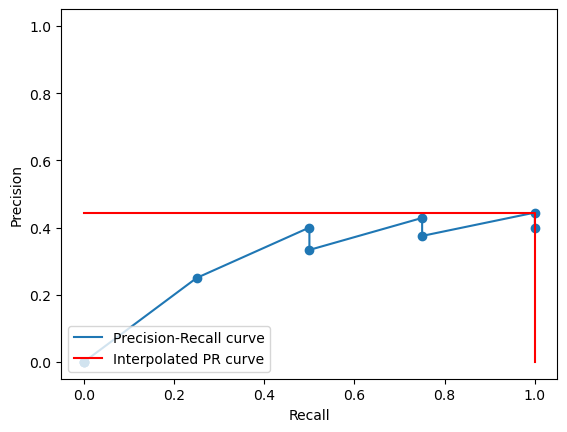

	Query 2


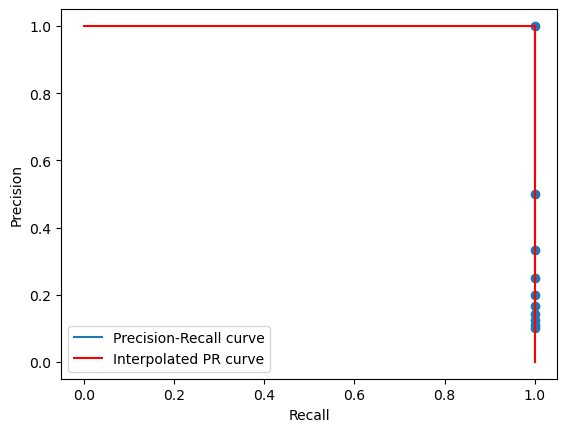

	Query 3


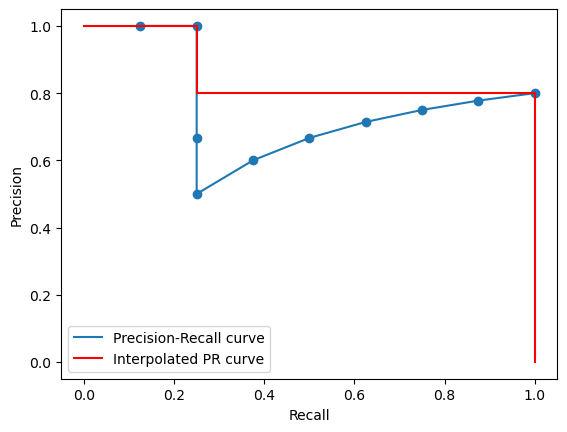

	Query 4


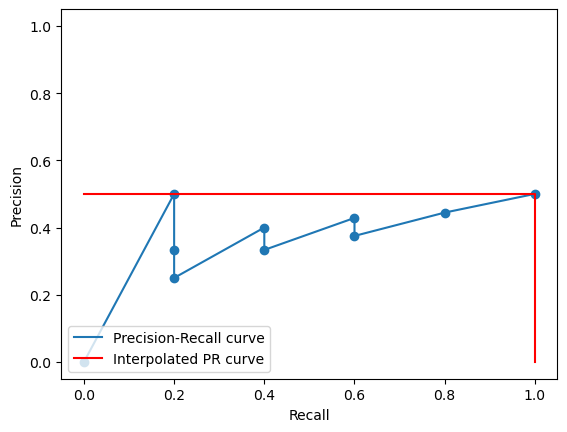

	Query 5


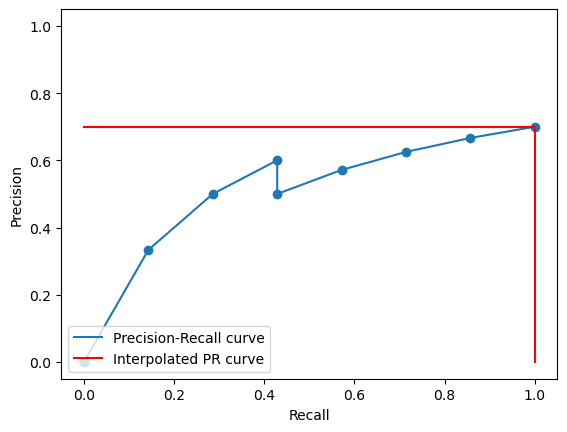

	Query 6


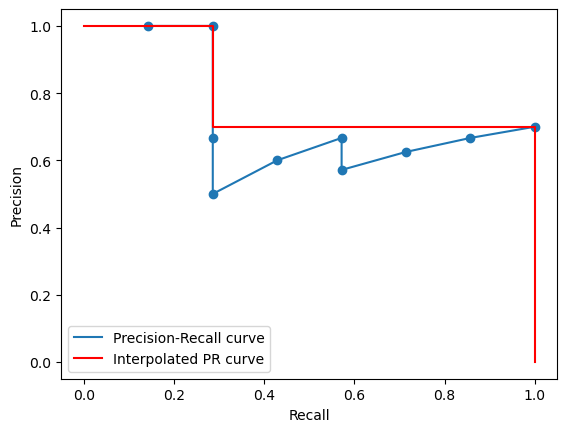

	Query 7


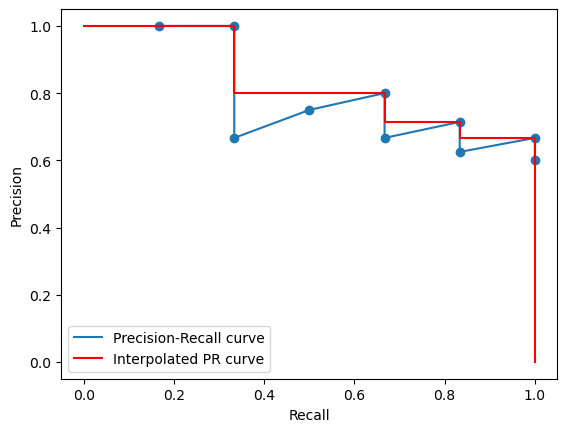

	Query 8


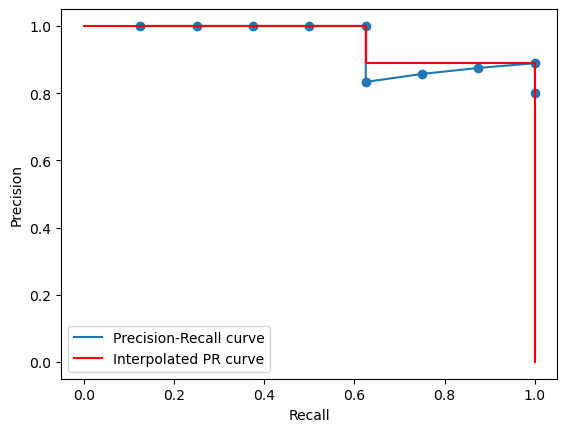

	Query 9


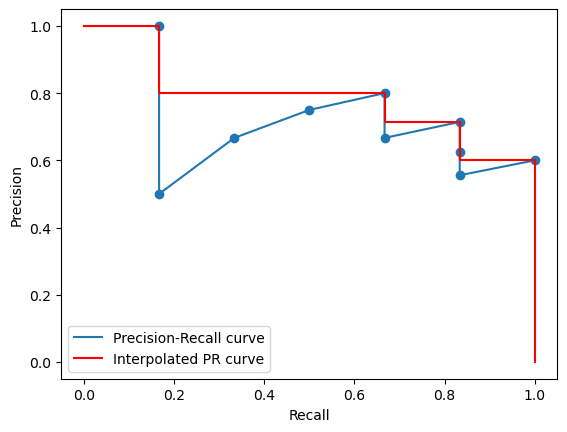

	Query 10


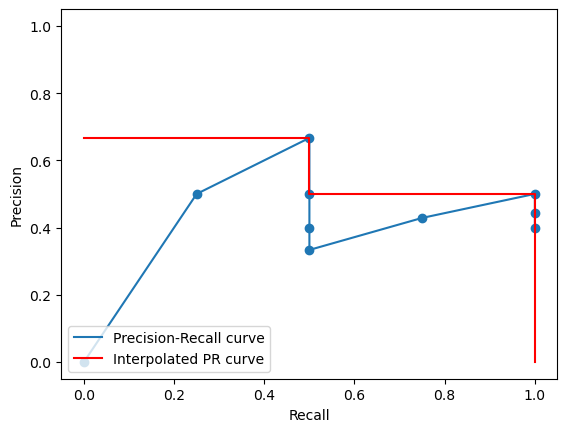


 Determine R-precision for each query
	Query 1
		Number of relevant documents: 4 --> P(4)=0.25
	Query 2
		Number of relevant documents: 1 --> P(1)=1.00
	Query 3
		Number of relevant documents: 8 --> P(8)=0.75
	Query 4
		Number of relevant documents: 5 --> P(5)=0.40
	Query 5
		Number of relevant documents: 7 --> P(7)=0.57
	Query 6
		Number of relevant documents: 7 --> P(7)=0.57
	Query 7
		Number of relevant documents: 6 --> P(6)=0.67
	Query 8
		Number of relevant documents: 8 --> P(8)=0.88
	Query 9
		Number of relevant documents: 6 --> P(6)=0.67
	Query 10
		Number of relevant documents: 4 --> P(4)=0.50

 Calculate the Mean Average Precision
	Query 1
		AP=1/4 {P(4) + P(5) + P(7) + P(9)}=0.38
	Query 2
		AP=1/1 {P(1)}=1.00
	Query 3
		AP=1/8 {P(1) + P(2) + P(5) + P(6) + P(7) + P(8) + P(9) + P(10)}=0.79
	Query 4
		AP=1/5 {P(2) + P(5) + P(7) + P(9) + P(10)}=0.45
	Query 5
		AP=1/7 {P(3) + P(4) + P(5) + P(7) + P(8) + P(9) + P(10)}=0.57
	Query 6
		AP=1/7 {P(1) + P(2) + P(5) + P(6) + P(8) + P(9)

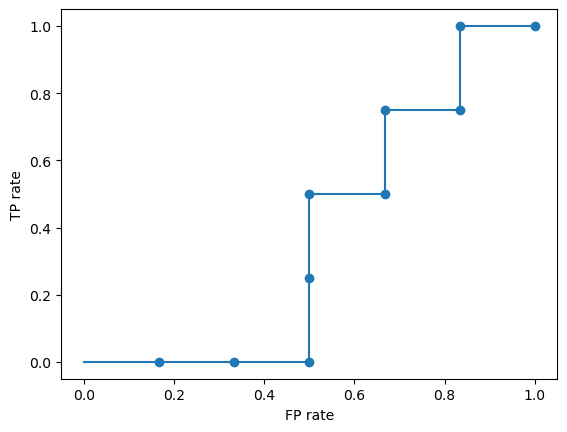

	AUC = 0.08 + 0.13 + 0.17 =  0.38


	Query 2


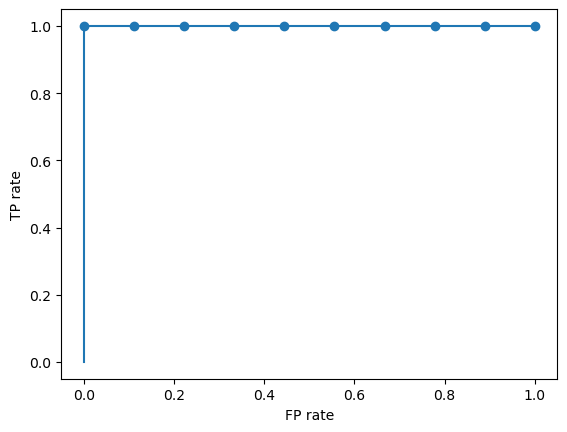

	AUC = 0.11 + 0.11 + 0.11 + 0.11 + 0.11 + 0.11 + 0.11 + 0.11 + 0.11 =  1.00


	Query 3


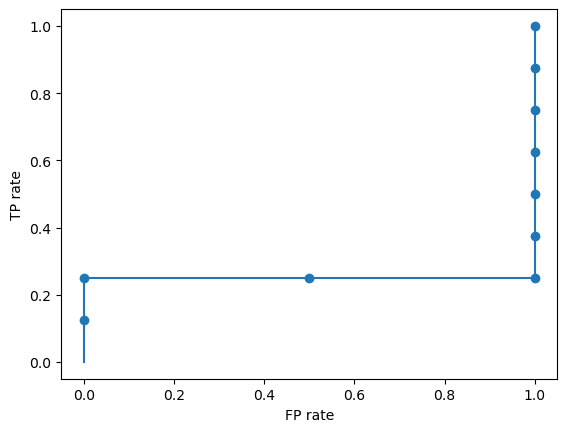

	AUC = 0.12 + 0.12 =  0.25


	Query 4


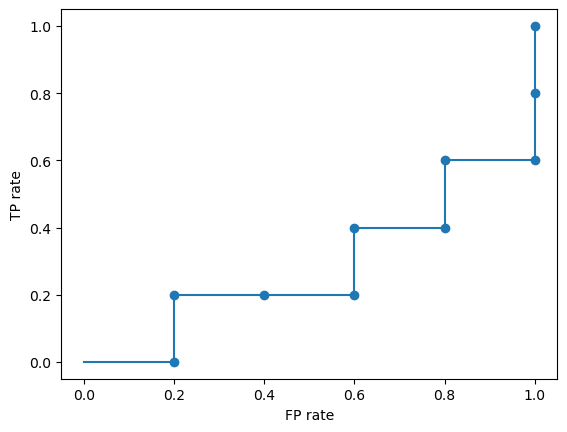

	AUC = 0.04 + 0.04 + 0.08 + 0.12 =  0.28


	Query 5


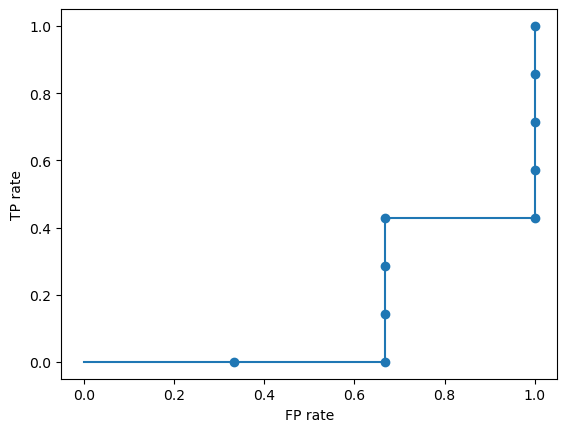

	AUC = 0.14 =  0.14


	Query 6


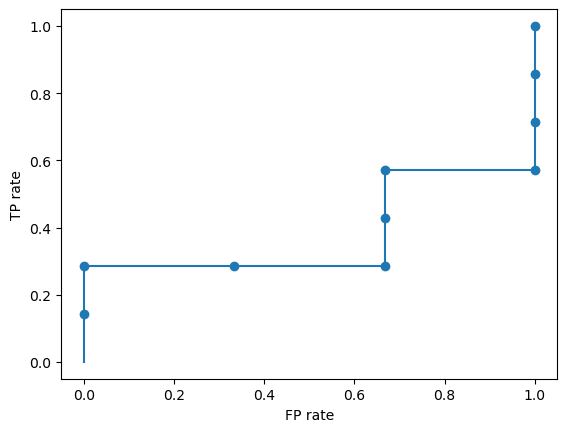

	AUC = 0.10 + 0.10 + 0.19 =  0.38


	Query 7


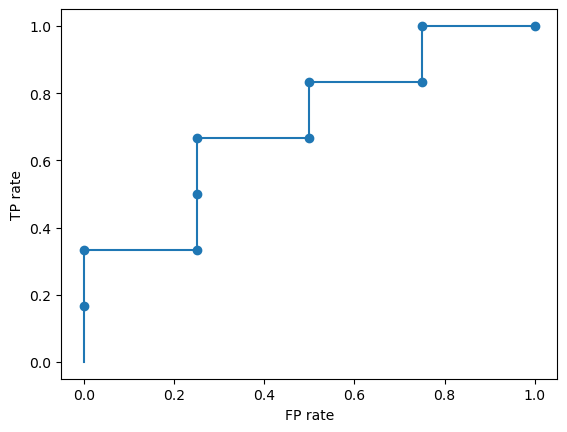

	AUC = 0.08 + 0.17 + 0.21 + 0.25 =  0.71


	Query 8


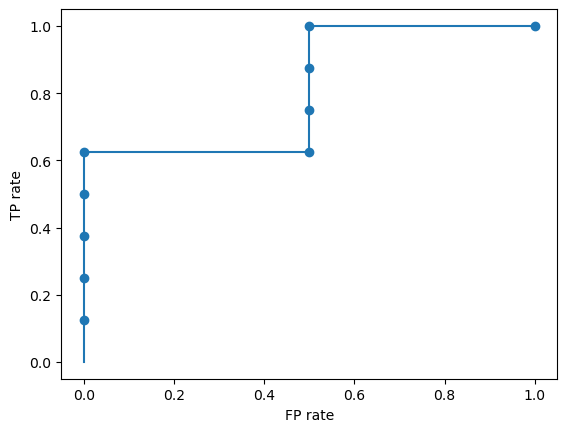

	AUC = 0.31 + 0.50 =  0.81


	Query 9


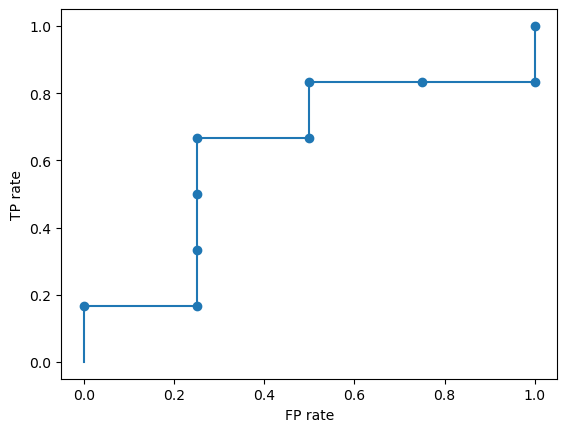

	AUC = 0.04 + 0.17 + 0.21 + 0.21 =  0.62


	Query 10


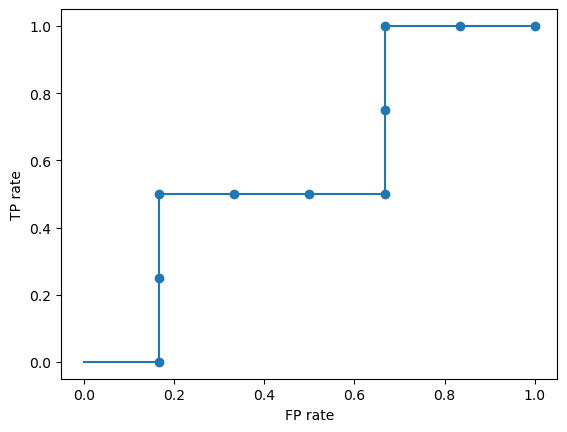

	AUC = 0.08 + 0.08 + 0.08 + 0.17 + 0.17 =  0.58


Precision and Recall at k for k=1,...,10
	Query 1
		P(1)=1/1=1.00,	R(1)=1/8=0.12
		P(2)=2/2=1.00,	R(2)=2/8=0.25
		P(3)=3/3=1.00,	R(3)=3/8=0.38
		P(4)=4/4=1.00,	R(4)=4/8=0.50
		P(5)=4/5=0.80,	R(5)=4/8=0.50
		P(6)=5/6=0.83,	R(6)=5/8=0.62
		P(7)=6/7=0.86,	R(7)=6/8=0.75
		P(8)=7/8=0.88,	R(8)=7/8=0.88
		P(9)=7/9=0.78,	R(9)=7/8=0.88
		P(10)=8/10=0.80,	R(10)=8/8=1.00
	Query 2
		P(1)=0/1=0.00,	R(1)=0/4=0.00
		P(2)=0/2=0.00,	R(2)=0/4=0.00
		P(3)=0/3=0.00,	R(3)=0/4=0.00
		P(4)=1/4=0.25,	R(4)=1/4=0.25
		P(5)=1/5=0.20,	R(5)=1/4=0.25
		P(6)=1/6=0.17,	R(6)=1/4=0.25
		P(7)=2/7=0.29,	R(7)=2/4=0.50
		P(8)=3/8=0.38,	R(8)=3/4=0.75
		P(9)=3/9=0.33,	R(9)=3/4=0.75
		P(10)=4/10=0.40,	R(10)=4/4=1.00
	Query 3
		P(1)=1/1=1.00,	R(1)=1/7=0.14
		P(2)=2/2=1.00,	R(2)=2/7=0.29
		P(3)=3/3=1.00,	R(3)=3/7=0.43
		P(4)=3/4=0.75,	R(4)=3/7=0.43
		P(5)=3/5=0.60,	R(5)=3/7=0.43
		P(6)=4/6=0.67,	R(6)=4/7=0.57
		P(7)=5/7=0.71,	R(7)=5/7=0.71
		P(8)=5/8=0.62,	R(8)=5/7=0.71
		P(9)=6

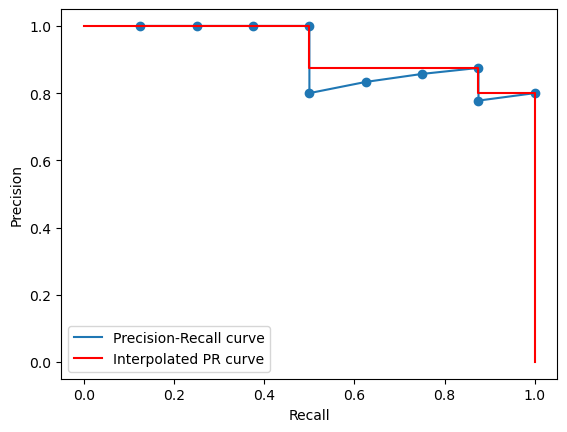

	Query 2


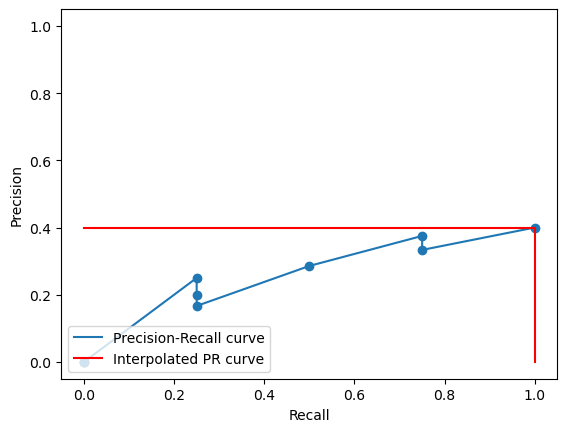

	Query 3


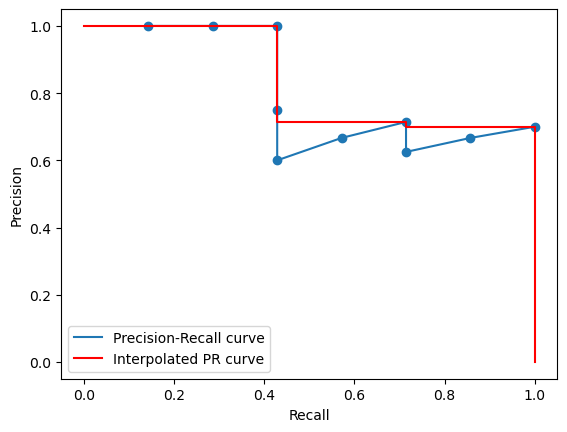

	Query 4


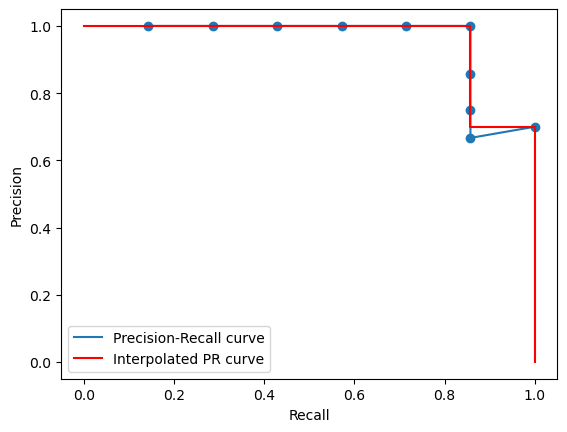

	Query 5


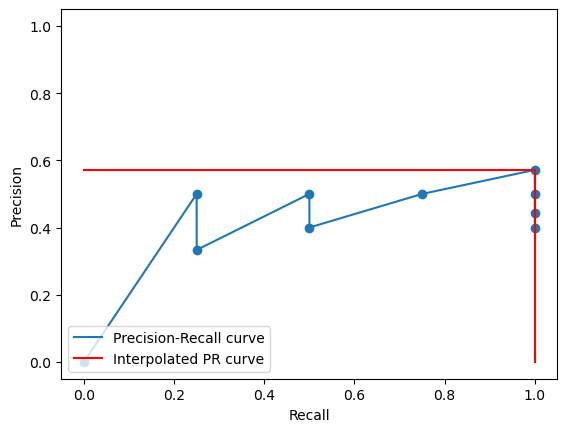

	Query 6


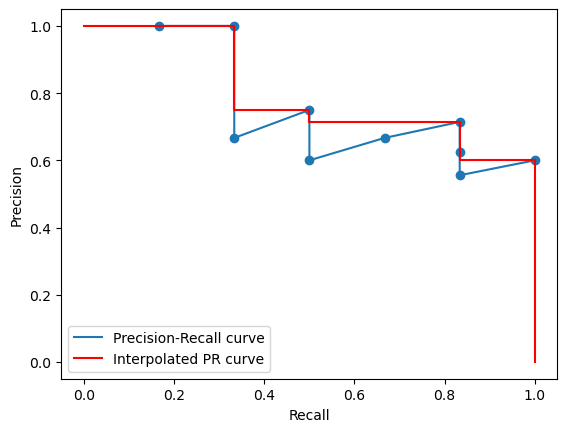

	Query 7


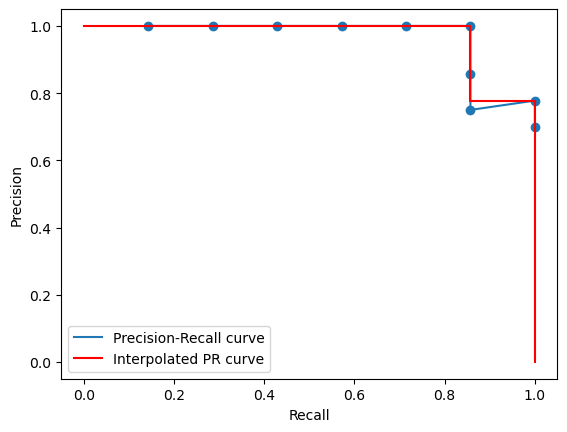

	Query 8


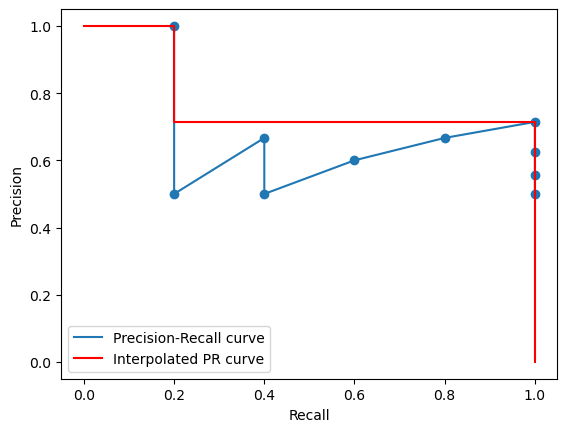

	Query 9


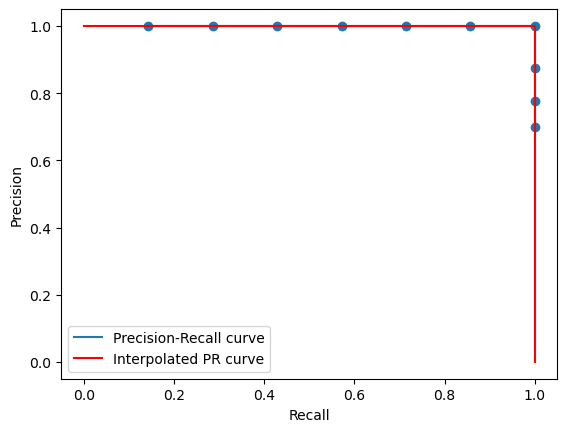

	Query 10


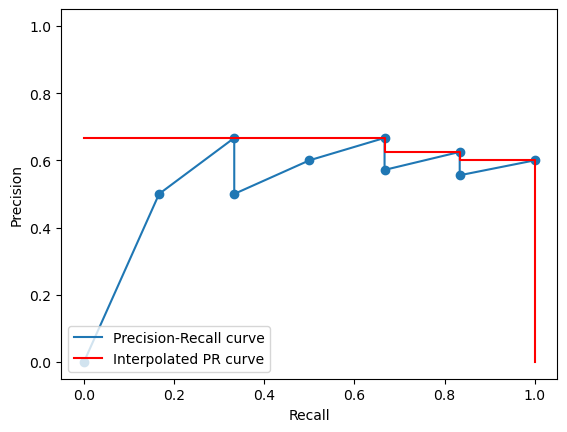


 Determine R-precision for each query
	Query 1
		Number of relevant documents: 8 --> P(8)=0.88
	Query 2
		Number of relevant documents: 4 --> P(4)=0.25
	Query 3
		Number of relevant documents: 7 --> P(7)=0.71
	Query 4
		Number of relevant documents: 7 --> P(7)=0.86
	Query 5
		Number of relevant documents: 4 --> P(4)=0.50
	Query 6
		Number of relevant documents: 6 --> P(6)=0.67
	Query 7
		Number of relevant documents: 7 --> P(7)=0.86
	Query 8
		Number of relevant documents: 5 --> P(5)=0.60
	Query 9
		Number of relevant documents: 7 --> P(7)=1.00
	Query 10
		Number of relevant documents: 6 --> P(6)=0.67

 Calculate the Mean Average Precision
	Query 1
		AP=1/8 {P(1) + P(2) + P(3) + P(4) + P(6) + P(7) + P(8) + P(10)}=0.92
	Query 2
		AP=1/4 {P(4) + P(7) + P(8) + P(10)}=0.33
	Query 3
		AP=1/7 {P(1) + P(2) + P(3) + P(6) + P(7) + P(9) + P(10)}=0.82
	Query 4
		AP=1/7 {P(1) + P(2) + P(3) + P(4) + P(5) + P(6) + P(10)}=0.96
	Query 5
		AP=1/4 {P(2) + P(4) + P(6) + P(7)}=0.52
	Query 6
		AP=1/6 {P(1

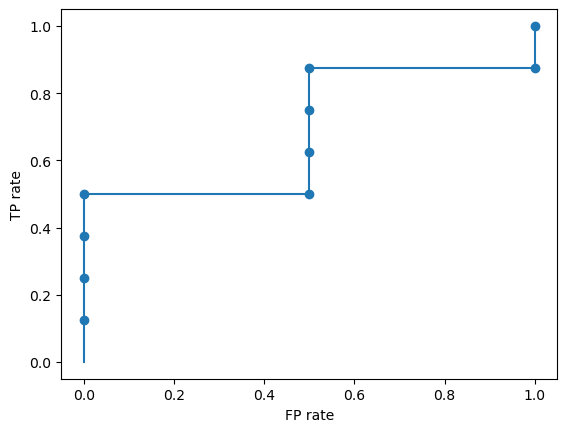

	AUC = 0.25 + 0.44 =  0.69


	Query 2


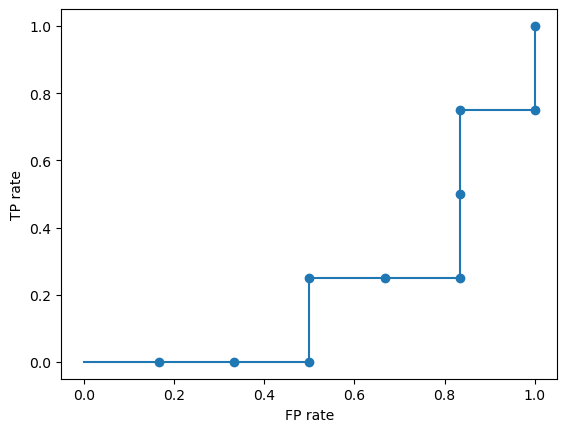

	AUC = 0.04 + 0.04 + 0.12 =  0.21


	Query 3


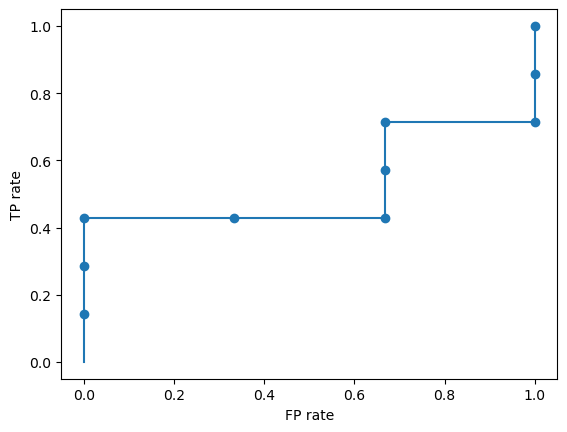

	AUC = 0.14 + 0.14 + 0.24 =  0.52


	Query 4


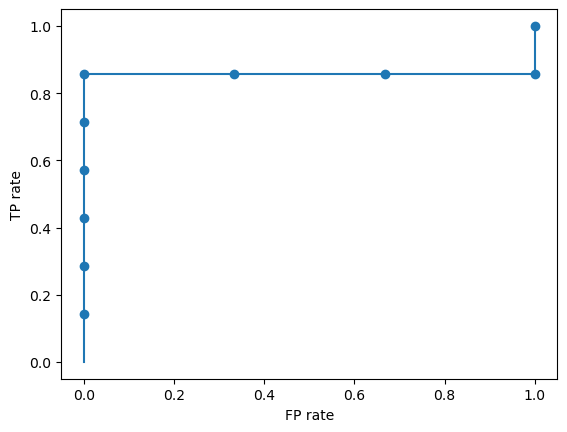

	AUC = 0.29 + 0.29 + 0.29 =  0.86


	Query 5


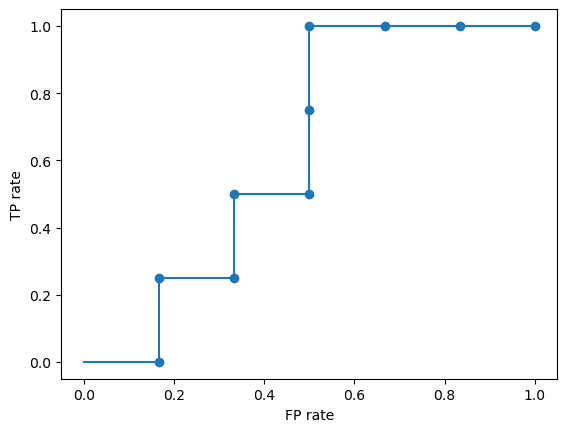

	AUC = 0.04 + 0.08 + 0.17 + 0.17 + 0.17 =  0.62


	Query 6


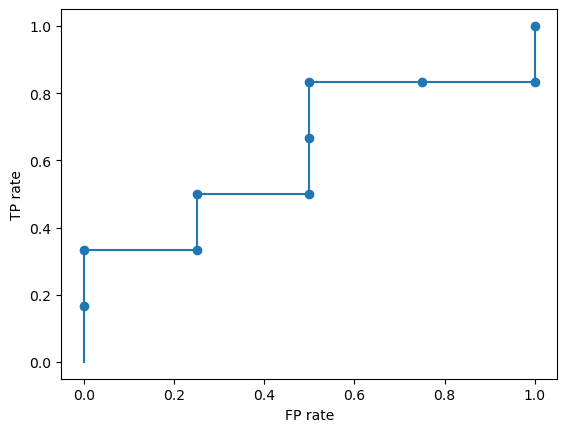

	AUC = 0.08 + 0.12 + 0.21 + 0.21 =  0.62


	Query 7


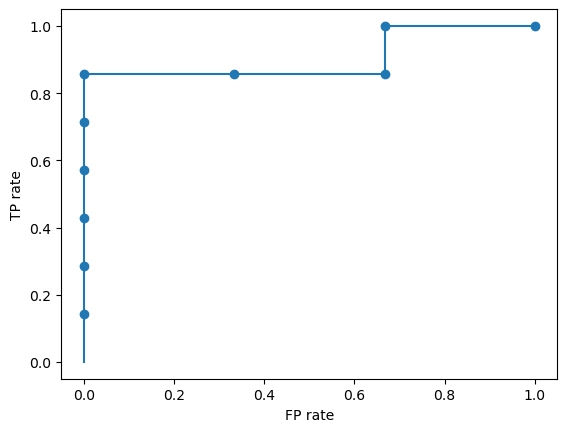

	AUC = 0.29 + 0.29 + 0.33 =  0.90


	Query 8


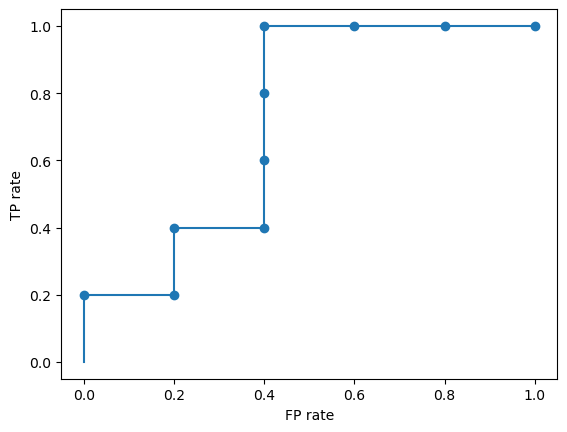

	AUC = 0.04 + 0.08 + 0.20 + 0.20 + 0.20 =  0.72


	Query 9


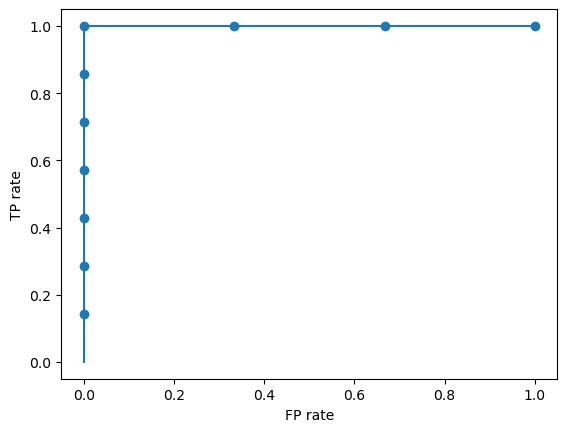

	AUC = 0.33 + 0.33 + 0.33 =  1.00


	Query 10


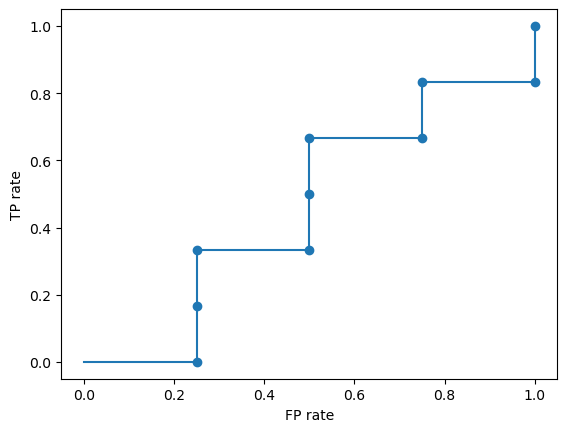

	AUC = 0.08 + 0.17 + 0.21 =  0.46


Precision and Recall at k for k=1,...,10
	Query 1
		P(1)=1/1=1.00,	R(1)=1/5=0.20
		P(2)=1/2=0.50,	R(2)=1/5=0.20
		P(3)=1/3=0.33,	R(3)=1/5=0.20
		P(4)=2/4=0.50,	R(4)=2/5=0.40
		P(5)=3/5=0.60,	R(5)=3/5=0.60
		P(6)=4/6=0.67,	R(6)=4/5=0.80
		P(7)=4/7=0.57,	R(7)=4/5=0.80
		P(8)=4/8=0.50,	R(8)=4/5=0.80
		P(9)=5/9=0.56,	R(9)=5/5=1.00
		P(10)=5/10=0.50,	R(10)=5/5=1.00
	Query 2
		P(1)=1/1=1.00,	R(1)=1/4=0.25
		P(2)=1/2=0.50,	R(2)=1/4=0.25
		P(3)=1/3=0.33,	R(3)=1/4=0.25
		P(4)=2/4=0.50,	R(4)=2/4=0.50
		P(5)=3/5=0.60,	R(5)=3/4=0.75
		P(6)=3/6=0.50,	R(6)=3/4=0.75
		P(7)=3/7=0.43,	R(7)=3/4=0.75
		P(8)=4/8=0.50,	R(8)=4/4=1.00
		P(9)=4/9=0.44,	R(9)=4/4=1.00
		P(10)=4/10=0.40,	R(10)=4/4=1.00
	Query 3
		P(1)=1/1=1.00,	R(1)=1/4=0.25
		P(2)=1/2=0.50,	R(2)=1/4=0.25
		P(3)=2/3=0.67,	R(3)=2/4=0.50
		P(4)=3/4=0.75,	R(4)=3/4=0.75
		P(5)=3/5=0.60,	R(5)=3/4=0.75
		P(6)=3/6=0.50,	R(6)=3/4=0.75
		P(7)=3/7=0.43,	R(7)=3/4=0.75
		P(8)=3/8=0.38,	R(8)=3/4=0.75
		P(9)=4/9=0.44,	R(9)=

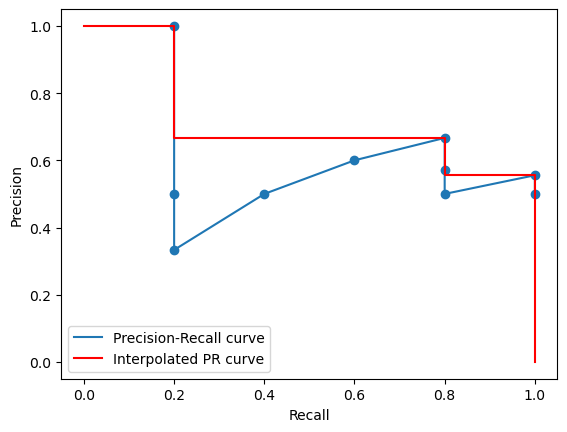

	Query 2


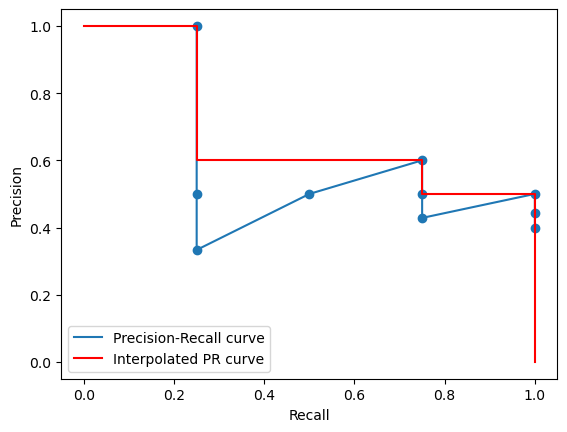

	Query 3


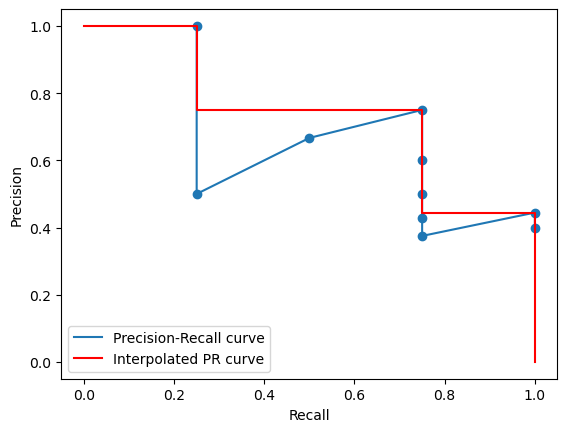

	Query 4


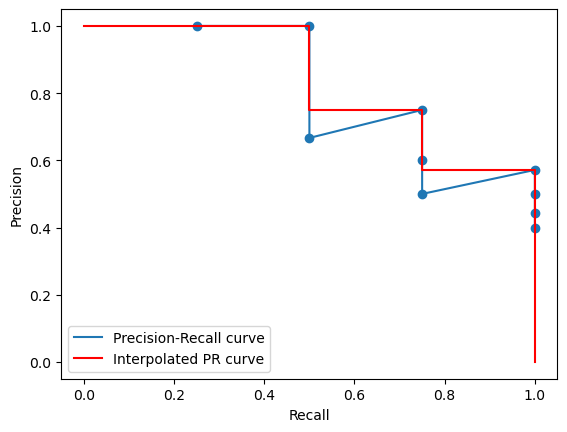

	Query 5


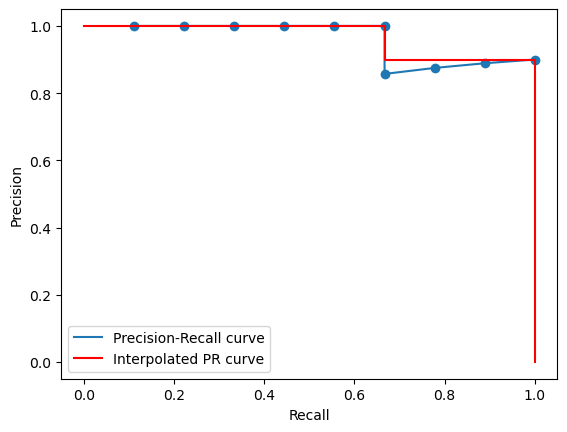

	Query 6


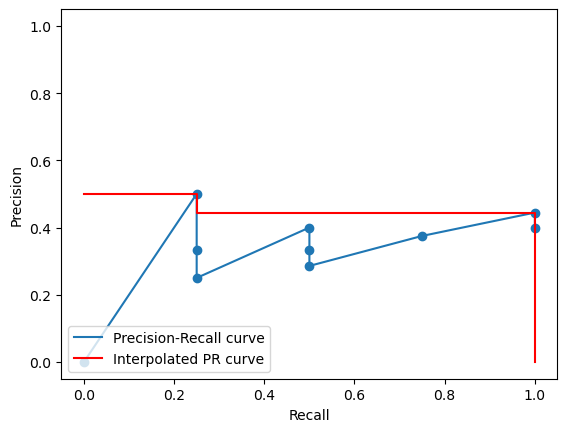

	Query 7


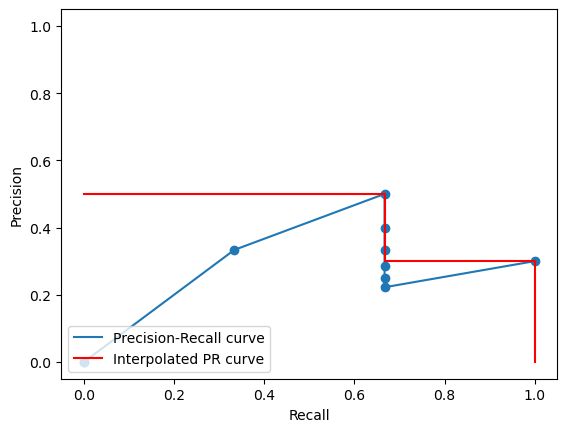

	Query 8


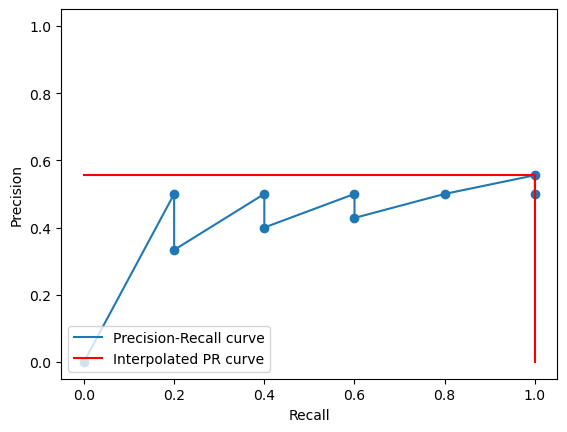

	Query 9


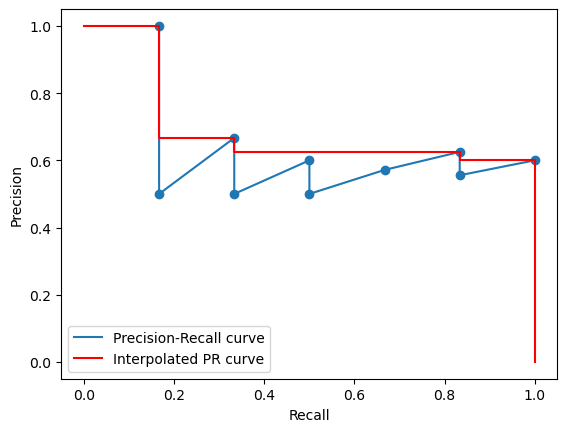

	Query 10


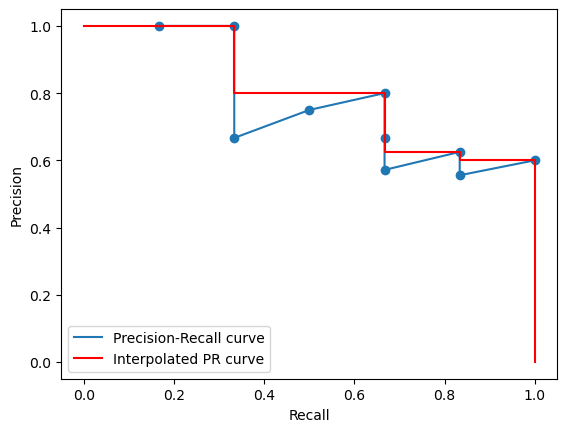


 Determine R-precision for each query
	Query 1
		Number of relevant documents: 5 --> P(5)=0.60
	Query 2
		Number of relevant documents: 4 --> P(4)=0.50
	Query 3
		Number of relevant documents: 4 --> P(4)=0.75
	Query 4
		Number of relevant documents: 4 --> P(4)=0.75
	Query 5
		Number of relevant documents: 9 --> P(9)=0.89
	Query 6
		Number of relevant documents: 4 --> P(4)=0.25
	Query 7
		Number of relevant documents: 3 --> P(3)=0.33
	Query 8
		Number of relevant documents: 5 --> P(5)=0.40
	Query 9
		Number of relevant documents: 6 --> P(6)=0.50
	Query 10
		Number of relevant documents: 6 --> P(6)=0.67

 Calculate the Mean Average Precision
	Query 1
		AP=1/5 {P(1) + P(4) + P(5) + P(6) + P(9)}=0.66
	Query 2
		AP=1/4 {P(1) + P(4) + P(5) + P(8)}=0.65
	Query 3
		AP=1/4 {P(1) + P(3) + P(4) + P(9)}=0.72
	Query 4
		AP=1/4 {P(1) + P(2) + P(4) + P(7)}=0.83
	Query 5
		AP=1/9 {P(1) + P(2) + P(3) + P(4) + P(5) + P(6) + P(8) + P(9) + P(10)}=0.96
	Query 6
		AP=1/4 {P(2) + P(5) + P(8) + P(9)}=0.43
	Q

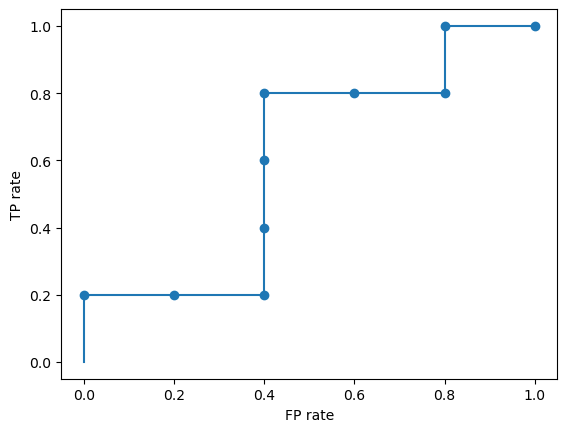

	AUC = 0.04 + 0.04 + 0.16 + 0.16 + 0.20 =  0.60


	Query 2


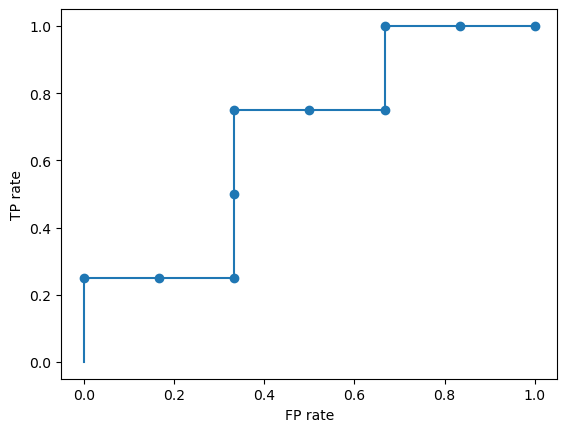

	AUC = 0.04 + 0.04 + 0.12 + 0.12 + 0.17 + 0.17 =  0.67


	Query 3


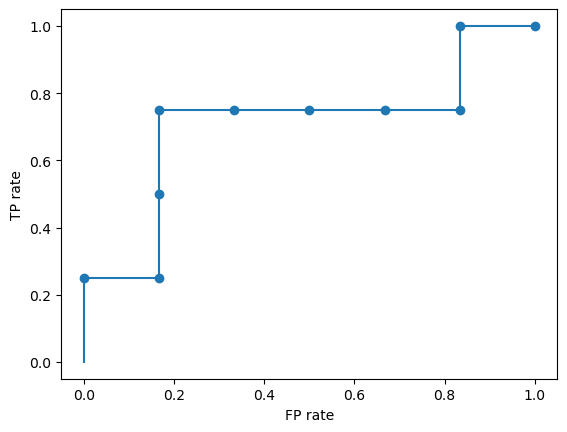

	AUC = 0.04 + 0.12 + 0.12 + 0.12 + 0.13 + 0.17 =  0.71


	Query 4


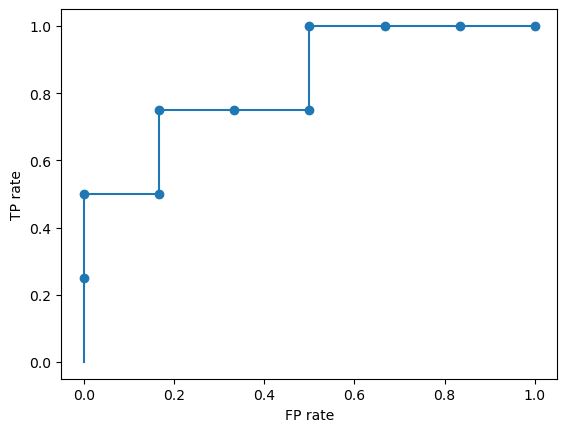

	AUC = 0.08 + 0.12 + 0.12 + 0.17 + 0.17 + 0.17 =  0.83


	Query 5


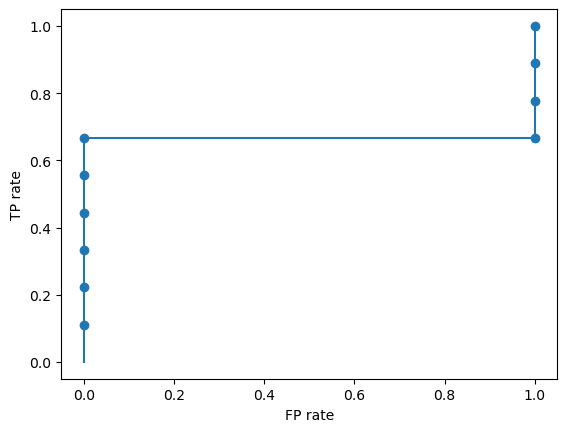

	AUC = 0.67 =  0.67


	Query 6


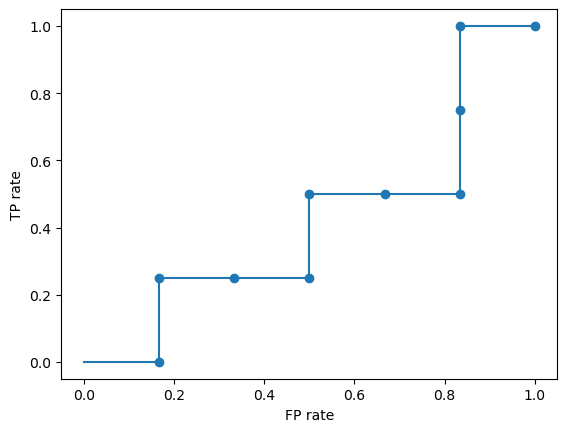

	AUC = 0.04 + 0.04 + 0.08 + 0.08 + 0.17 =  0.42


	Query 7


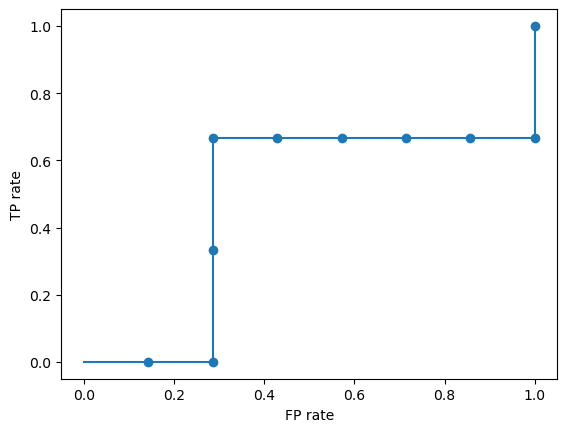

	AUC = 0.10 + 0.10 + 0.10 + 0.10 + 0.10 =  0.48


	Query 8


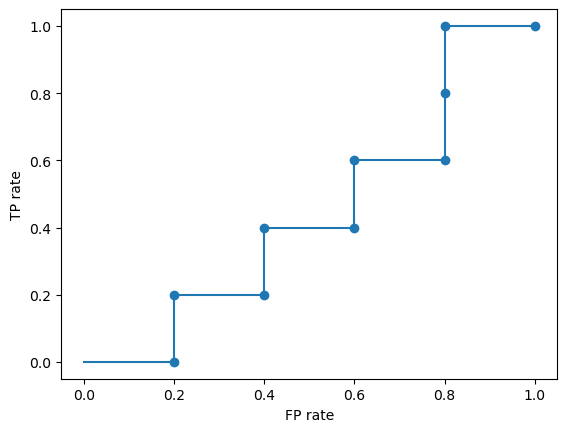

	AUC = 0.04 + 0.08 + 0.12 + 0.20 =  0.44


	Query 9


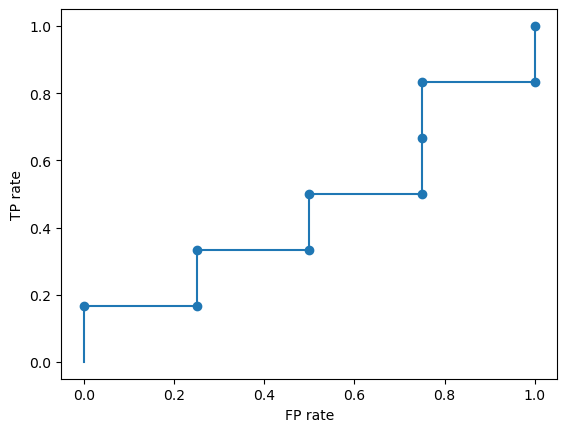

	AUC = 0.04 + 0.08 + 0.12 + 0.21 =  0.46


	Query 10


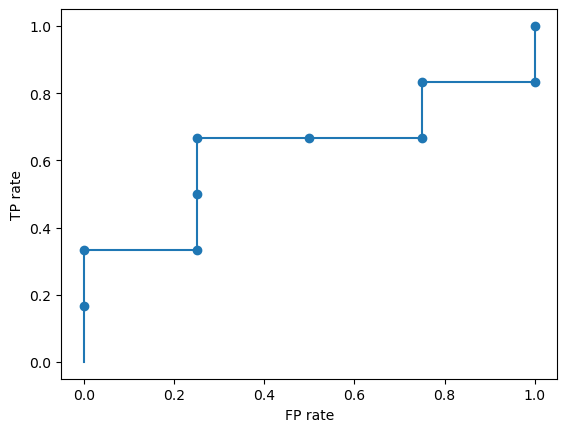

	AUC = 0.08 + 0.17 + 0.17 + 0.21 =  0.62


Precision and Recall at k for k=1,...,10
	Query 1
		P(1)=0/1=0.00,	R(1)=0/6=0.00
		P(2)=0/2=0.00,	R(2)=0/6=0.00
		P(3)=1/3=0.33,	R(3)=1/6=0.17
		P(4)=1/4=0.25,	R(4)=1/6=0.17
		P(5)=1/5=0.20,	R(5)=1/6=0.17
		P(6)=2/6=0.33,	R(6)=2/6=0.33
		P(7)=3/7=0.43,	R(7)=3/6=0.50
		P(8)=4/8=0.50,	R(8)=4/6=0.67
		P(9)=5/9=0.56,	R(9)=5/6=0.83
		P(10)=6/10=0.60,	R(10)=6/6=1.00
	Query 2
		P(1)=1/1=1.00,	R(1)=1/6=0.17
		P(2)=2/2=1.00,	R(2)=2/6=0.33
		P(3)=2/3=0.67,	R(3)=2/6=0.33
		P(4)=2/4=0.50,	R(4)=2/6=0.33
		P(5)=3/5=0.60,	R(5)=3/6=0.50
		P(6)=4/6=0.67,	R(6)=4/6=0.67
		P(7)=5/7=0.71,	R(7)=5/6=0.83
		P(8)=5/8=0.62,	R(8)=5/6=0.83
		P(9)=5/9=0.56,	R(9)=5/6=0.83
		P(10)=6/10=0.60,	R(10)=6/6=1.00
	Query 3
		P(1)=0/1=0.00,	R(1)=0/4=0.00
		P(2)=1/2=0.50,	R(2)=1/4=0.25
		P(3)=1/3=0.33,	R(3)=1/4=0.25
		P(4)=1/4=0.25,	R(4)=1/4=0.25
		P(5)=1/5=0.20,	R(5)=1/4=0.25
		P(6)=2/6=0.33,	R(6)=2/4=0.50
		P(7)=2/7=0.29,	R(7)=2/4=0.50
		P(8)=3/8=0.38,	R(8)=3/4=0.75
		P(9)=3/9=0.33

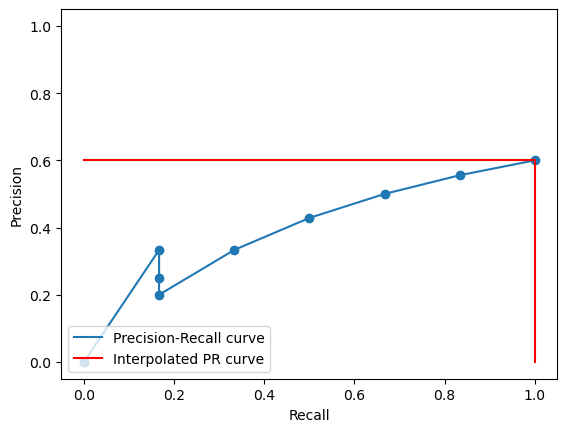

	Query 2


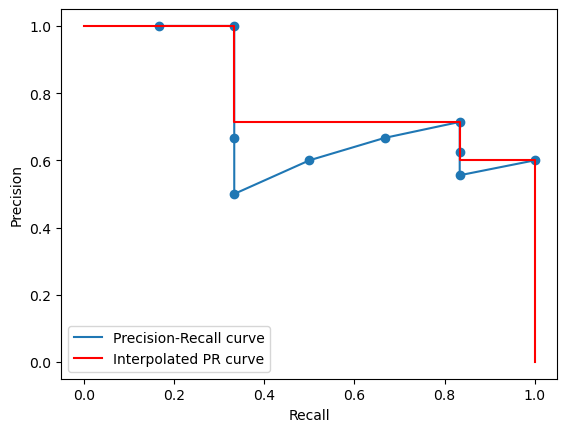

	Query 3


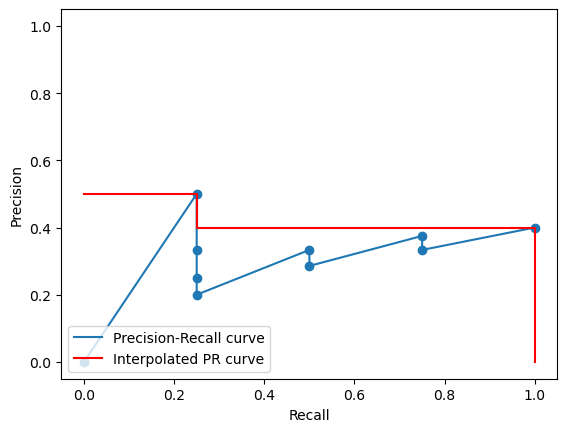

	Query 4


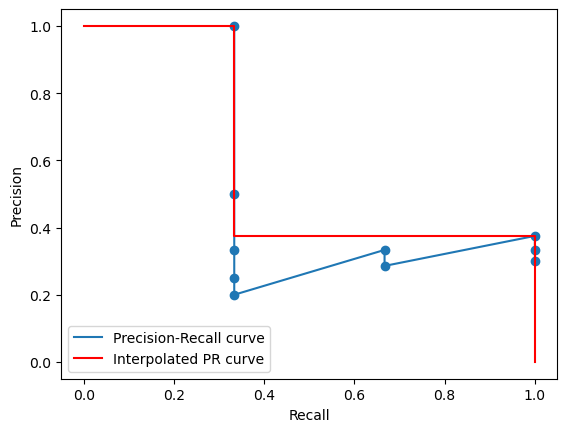

	Query 5


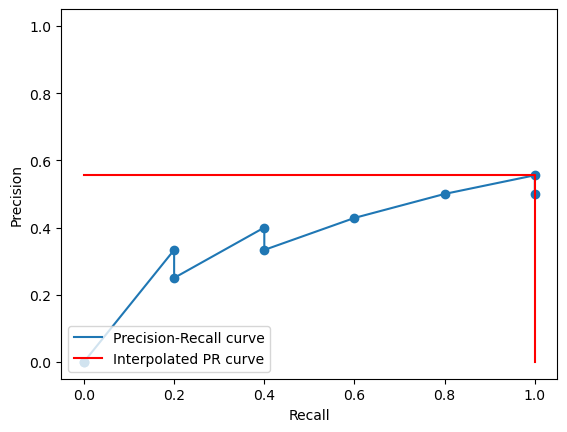

	Query 6


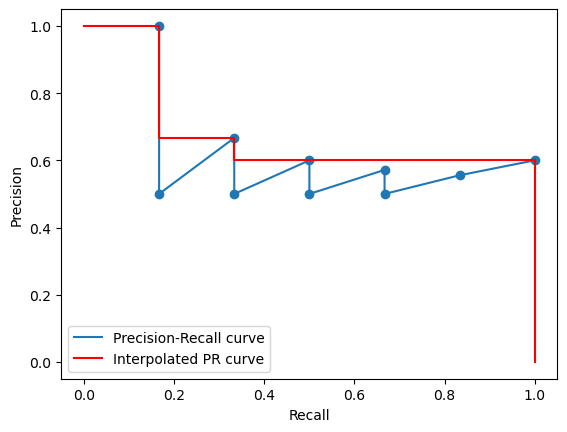

	Query 7


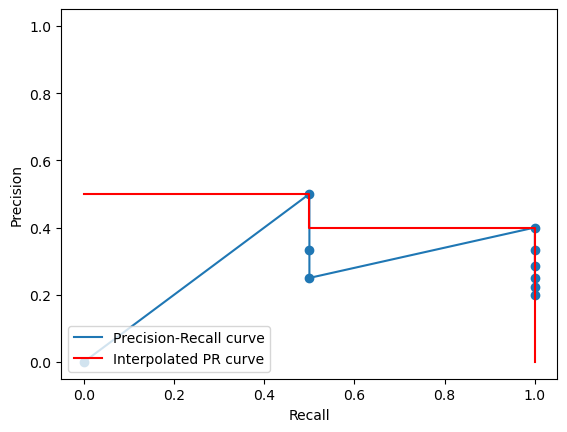

	Query 8


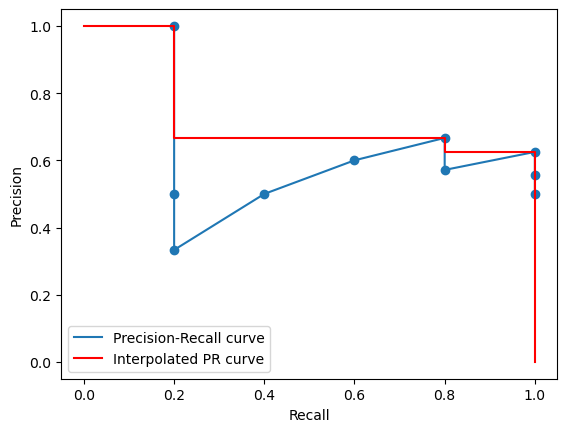

	Query 9


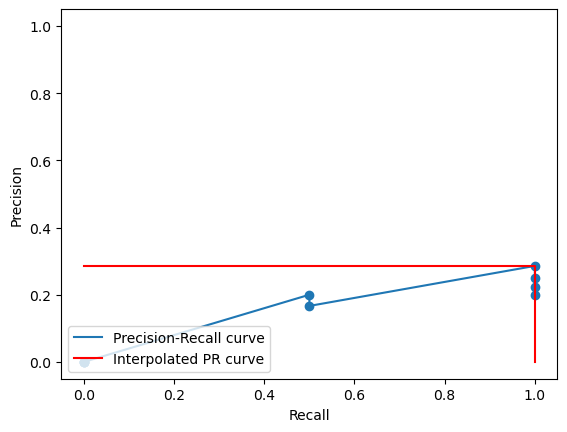

	Query 10


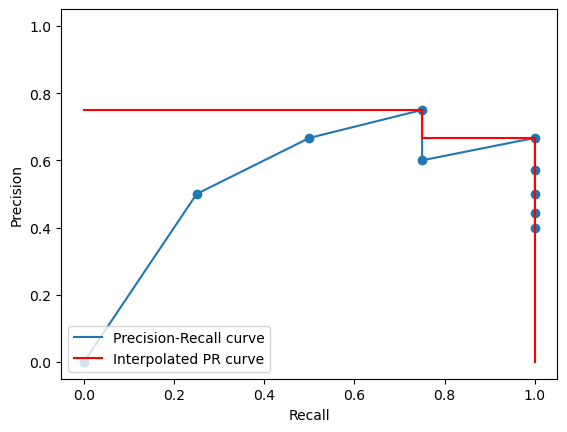


 Determine R-precision for each query
	Query 1
		Number of relevant documents: 6 --> P(6)=0.33
	Query 2
		Number of relevant documents: 6 --> P(6)=0.67
	Query 3
		Number of relevant documents: 4 --> P(4)=0.25
	Query 4
		Number of relevant documents: 3 --> P(3)=0.33
	Query 5
		Number of relevant documents: 5 --> P(5)=0.40
	Query 6
		Number of relevant documents: 6 --> P(6)=0.50
	Query 7
		Number of relevant documents: 2 --> P(2)=0.50
	Query 8
		Number of relevant documents: 5 --> P(5)=0.60
	Query 9
		Number of relevant documents: 2 --> P(2)=0.00
	Query 10
		Number of relevant documents: 4 --> P(4)=0.75

 Calculate the Mean Average Precision
	Query 1
		AP=1/6 {P(3) + P(6) + P(7) + P(8) + P(9) + P(10)}=0.46
	Query 2
		AP=1/6 {P(1) + P(2) + P(5) + P(6) + P(7) + P(10)}=0.76
	Query 3
		AP=1/4 {P(2) + P(6) + P(8) + P(10)}=0.40
	Query 4
		AP=1/3 {P(1) + P(6) + P(8)}=0.57
	Query 5
		AP=1/5 {P(3) + P(5) + P(7) + P(8) + P(9)}=0.44
	Query 6
		AP=1/6 {P(1) + P(3) + P(5) + P(7) + P(9) + P(10)}=0.67

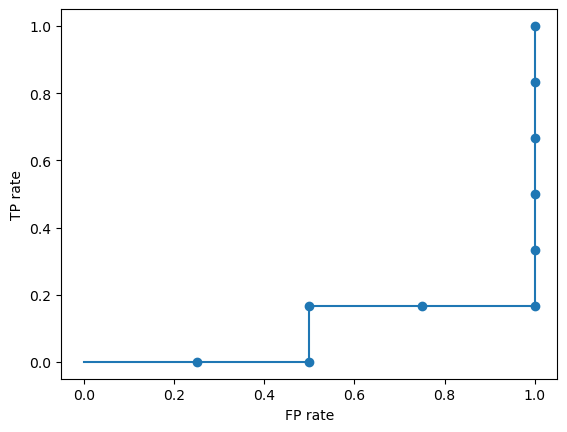

	AUC = 0.04 + 0.04 =  0.08


	Query 2


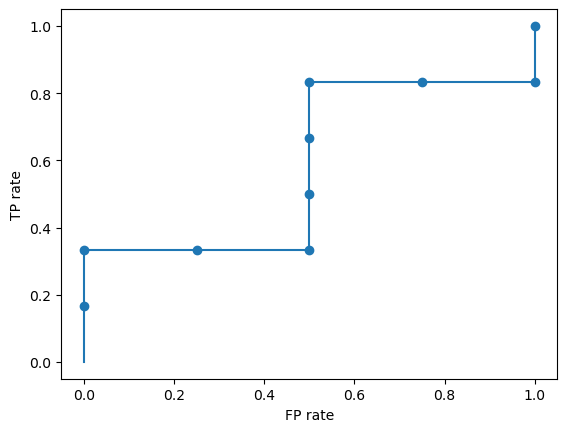

	AUC = 0.08 + 0.08 + 0.21 + 0.21 =  0.58


	Query 3


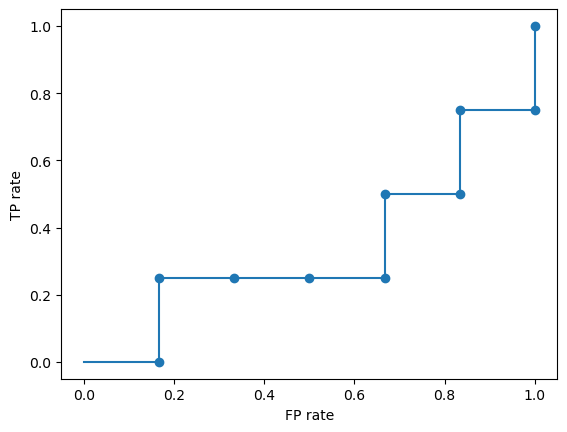

	AUC = 0.04 + 0.04 + 0.04 + 0.08 + 0.12 =  0.33


	Query 4


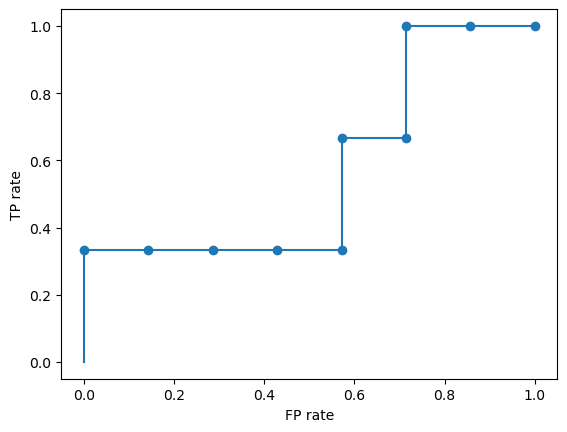

	AUC = 0.05 + 0.05 + 0.05 + 0.05 + 0.10 + 0.14 + 0.14 =  0.57


	Query 5


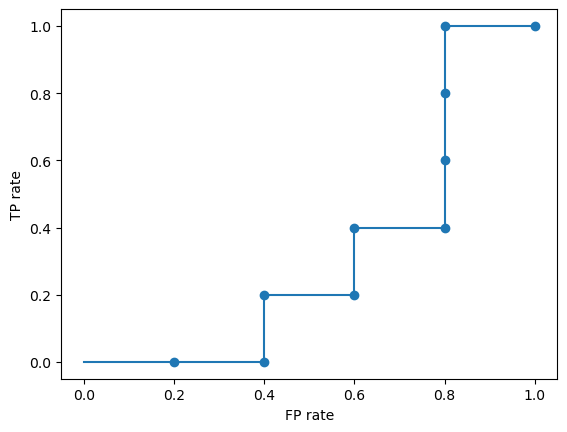

	AUC = 0.04 + 0.08 + 0.20 =  0.32


	Query 6


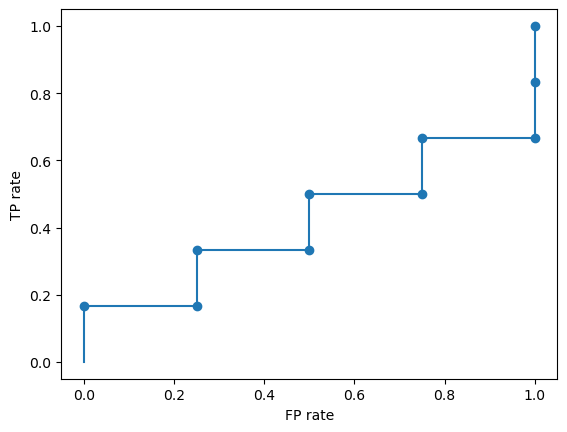

	AUC = 0.04 + 0.08 + 0.12 + 0.17 =  0.42


	Query 7


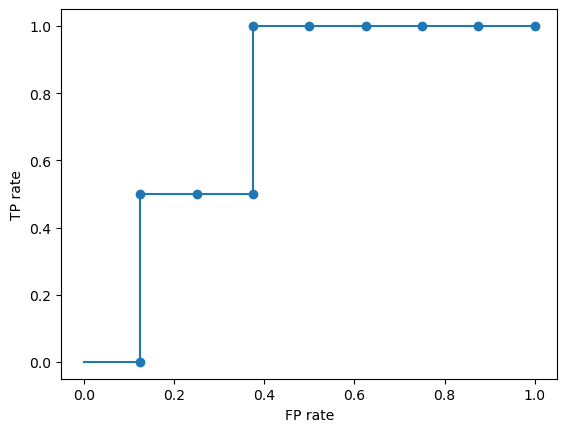

	AUC = 0.06 + 0.06 + 0.12 + 0.12 + 0.12 + 0.12 + 0.12 =  0.75


	Query 8


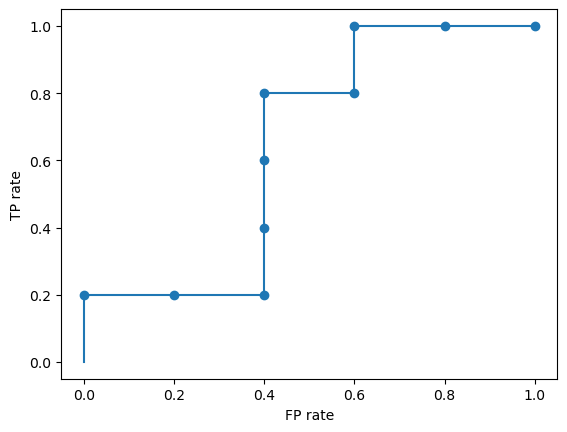

	AUC = 0.04 + 0.04 + 0.16 + 0.20 + 0.20 =  0.64


	Query 9


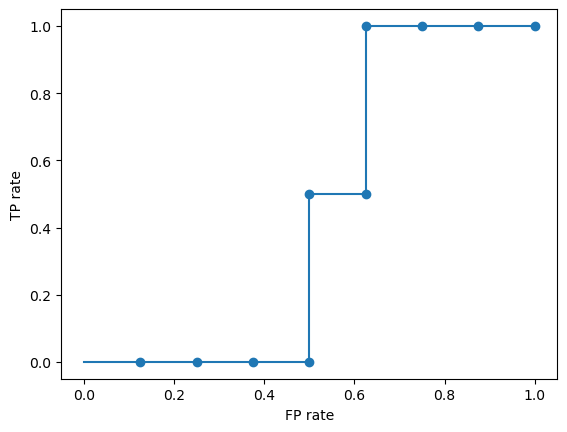

	AUC = 0.06 + 0.12 + 0.12 + 0.12 =  0.44


	Query 10


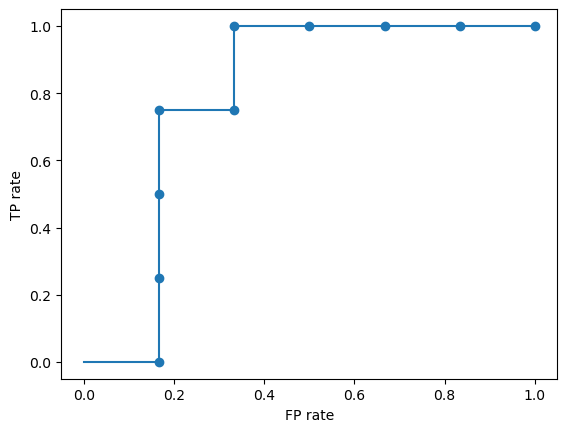

	AUC = 0.12 + 0.17 + 0.17 + 0.17 + 0.17 =  0.79




In [98]:
# Now, let's evaluate the recommended documents for each user
for user_id, relevant_documents in user_relevant_documents.items():
    # Extracting query and relevance judgements for evaluation
    Q, R = gen_eval_dataset(len(relevant_documents), num_documents_to_retrieve)
    
    # Evaluate the recommended documents
    evaluate('all', Q, R)

# Using word embeddings

In [20]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api

# Load pre-trained word embeddings
word_embeddings_model = api.load("word2vec-google-news-300")


In [26]:
# Function to generate document embeddings
def generate_document_embeddings(documents, word_embeddings_model):
    document_embeddings = []
    for doc in documents:
        # Aggregate word embeddings (e.g., by averaging)
        words = doc.split()
        embeddings = [word_embeddings_model[word] for word in words if word in word_embeddings_model]
        if embeddings:
            doc_embedding = np.mean(embeddings, axis=0)  # Average embeddings
            document_embeddings.append(doc_embedding)
    return np.array(document_embeddings)

# Function to retrieve relevant documents for a query
def retrieve_documents(query_embedding, document_embeddings, documents, top_k=10):
    similarity_scores = cosine_similarity(query_embedding.reshape(1, -1), document_embeddings)[0]
    top_documents_indices = similarity_scores.argsort()[-top_k:][::-1]
    top_documents = [(documents[i], similarity_scores[i]) for i in top_documents_indices]
    return top_documents

In [28]:

# Example documents 
documents = data['Text']
# Generate document embeddings
document_embeddings = generate_document_embeddings(documents, word_embeddings_model)

# Process user queries
for user_id, interests in user_interests.items():
    # Aggregate word embeddings for the user's interests to generate the query embedding
    query_embedding = np.mean([word_embeddings_model[word] for interest in interests for word in interest.split() if word in word_embeddings_model], axis=0)
    
    # Retrieve relevant documents for the user's query
    relevant_documents = retrieve_documents(query_embedding, document_embeddings, documents)

    # Store relevant documents for evaluation
    user_relevant_documents[user_id] = relevant_documents
    
    # Print or process relevant documents
    print("User", user_id, "Interests:", interests)
    for doc, score in relevant_documents:
        print("     Document:", doc, "Similarity Score:", score)
    

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2225,) + inhomogeneous part.

     Document: munster switched spain munster heineken quarter final biarritz april switched real sociedad paseo anoeta stadium sebastian real ground hold whereas parc sport aguilera biarritz capacity irish province given least ticket decision move difficult considered fan primary objective said biarritz chairman marcel martin hope rewarded huge crowd behaving best rugby tradition match first heineken fixture played spain expected attract biggest ever attendance rugby match country ulster last irish team play paseo anoeta stadium faced euskarians side season tour Similarity Score: 0.5979421


In [99]:
user_relevant_documents

{0: [('software patent face european parliament thrown bill would allowed software patented politician unanimously rejected bill must another round consultation chance becoming consultation software patent bill could substantially drafted even scrapped bill backed tech firm saying needed protection offered make research worthwhile hugo lueders european director public policy comptia umbrella organization technology company said intellectual property adequately protected would european inventor prosper said benefit bill obscured special interest group muddied debate right wrong software patent proponent bill said good compromise avoided excess american system allows patenting business practice well software opponent bill said could stifle innovation abused firm keen protect existing monopoly could hamper growth open source movement proposed troubled passage european parliament progress delayed twice polish meps rejected plan adopt also earlier month influential european legal affair com

In [111]:
for user_id, interests in user_interests.items():
    print(interests)

['politics', 'soccer']
['music', 'films']
['cars', 'politics']
['soccer']


Precision and Recall at k for k=1,...,2
	Query 1
		P(1)=0/1=0.75,	R(1)=0/7=0.10
		P(2)=1/2=0.75,	R(2)=1/7=0.20
	Query 2
		P(1)=0/1=0.82,	R(1)=0/7=0.10
		P(2)=1/2=0.81,	R(2)=1/7=0.20
	Query 3
		P(1)=0/1=0.77,	R(1)=0/7=0.10
		P(2)=1/2=0.76,	R(2)=1/7=0.21
	Query 4
		P(1)=0/1=0.75,	R(1)=0/7=0.10
		P(2)=1/2=0.73,	R(2)=1/7=0.21

 Draw the Precision-Recall curve for each query
	Query 1


ValueError: zero-size array to reduction operation maximum which has no identity

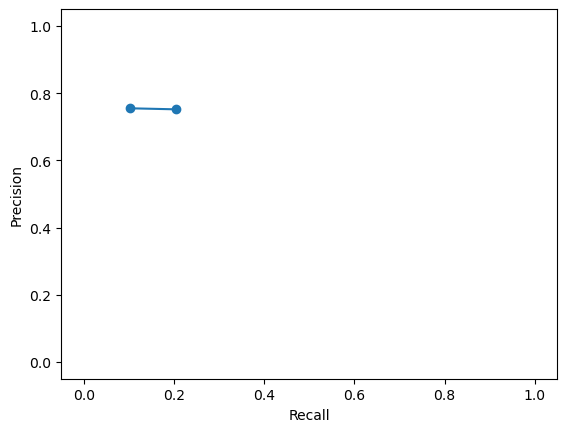

In [110]:
from evaltools import evaluate
# Initialize Q and R
Q = []
R = []

# Process user queries
for user_id, interests in user_interests.items():
    # Aggregate word embeddings for the user's interests to generate the query embedding
    query_embedding = np.mean([word_embeddings_model[word] for interest in interests for word in interest.split() if word in word_embeddings_model], axis=0)
    
    # Retrieve relevant documents for the user's query
    relevant_documents = retrieve_documents(query_embedding, document_embeddings, documents)

    # Store relevant documents for evaluation
    user_relevant_documents[user_id] = relevant_documents
    
    # Add user's interests to Q
    Q.append(interests)
    
    # Add relevant documents to R
    R.append([score for doc, score in relevant_documents])
# Now you can call the evaluate function
evaluate('all', Q, R)